BOX 1: reading packages

In [ ]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro, chisquare
import statsmodels.formula.api as sfm
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScalers
from sklearn.metrics import mean_squared_error, r2_score

BOX 2 reading the csv + checking each column for null values

In [73]:
df = pd.read_csv('udemy_database.csv')
has_nulls = df.isnull().any()
print(has_nulls)

course_id              False
course_title           False
url                    False
is_paid                False
price                  False
num_subscribers        False
num_reviews            False
num_lectures           False
level                  False
content_duration       False
published_timestamp    False
subject                False
dtype: bool


BOX 3 checking for duplicates - there where 6 duplicates

In [74]:
duplicates = df[df.duplicated(subset='course_id')]
print(f"Number of duplicates found: {len(duplicates)}")

df.drop_duplicates(subset='course_id', keep='first', inplace=True)

print(f"Row count after removing duplicates: {len(df)}")

df.to_csv('udemy_database.csv', index=False)
print("Duplicates removed, and original CSV updated.")

Number of duplicates found: 0
Row count after removing duplicates: 3672
Duplicates removed, and original CSV updated.


BOX 4: detecting outliers
method: https://bpb-us-w2.wpmucdn.com/sites.umassd.edu/dist/f/1316/files/2023/01/Statistics-for-Nursing-and-Allied-Health-PDFDrive-.pdf#page=34
Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69

In [75]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


In [76]:
mean = df["content_duration"].mean()
std_dev = df["content_duration"].std()

outliers = df[(df["content_duration"] < (mean - 3 * std_dev)) | (df["content_duration"] > (mean + 3 * std_dev))]

outliers.to_csv('outliers_content_duration.csv', index=False)

print("Outliers saved to 'outliers.csv'.")


Outliers saved to 'outliers.csv'.


BOX 4: the outliers intersection based on numeric variables

In [77]:
common_outliers_pairwise = {}

for col1, col2 in combinations(outliers_dict.keys(), 2):
    outliers_col1 = set(outliers_dict[col1]['course_id']) if isinstance(outliers_dict[col1], pd.DataFrame) else set(outliers_dict[col1])
    outliers_col2 = set(outliers_dict[col2]['course_id']) if isinstance(outliers_dict[col2], pd.DataFrame) else set(outliers_dict[col2])

    common_outliers = outliers_col1.intersection(outliers_col2)

    common_outliers_pairwise[f"{col1} & {col2}"] = common_outliers

for columns, common_outliers in common_outliers_pairwise.items():
    print(f"Common outliers for {columns}:", len(common_outliers))
    for course_id in common_outliers:
        print(f"  - Course ID {course_id}")
    print()



Common outliers for course_id & price: 0

Common outliers for course_id & num_subscribers: 0

Common outliers for course_id & num_reviews: 0

Common outliers for course_id & num_lectures: 0

Common outliers for course_id & content_duration: 0

Common outliers for price & num_subscribers: 0

Common outliers for price & num_reviews: 0

Common outliers for price & num_lectures: 0

Common outliers for price & content_duration: 0

Common outliers for num_subscribers & num_reviews: 20
  - Course ID 764164
  - Course ID 364426
  - Course ID 130064
  - Course ID 519442
  - Course ID 437398
  - Course ID 719002
  - Course ID 405926
  - Course ID 625204
  - Course ID 756150
  - Course ID 446134
  - Course ID 473160
  - Course ID 48841
  - Course ID 289230
  - Course ID 41295
  - Course ID 238934
  - Course ID 314462
  - Course ID 461160
  - Course ID 173548
  - Course ID 705264
  - Course ID 707962

Common outliers for num_subscribers & num_lectures: 10
  - Course ID 764164
  - Course ID 11174
 

BOX 6: plotting the data to better see the outliers

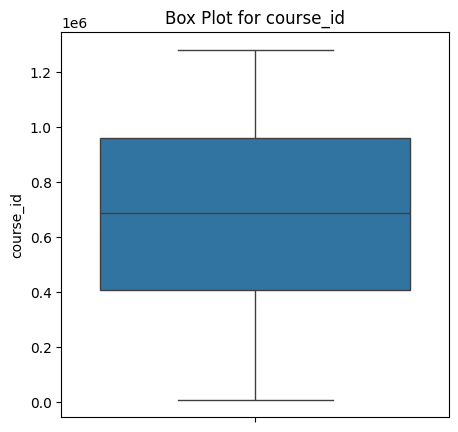

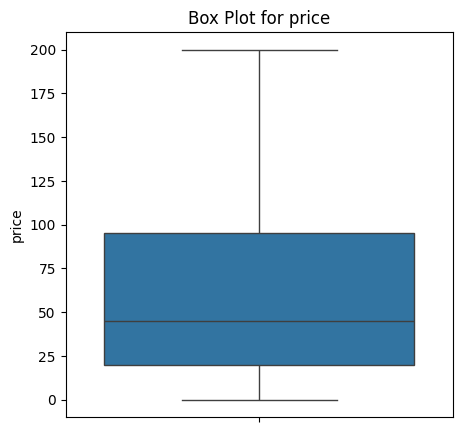

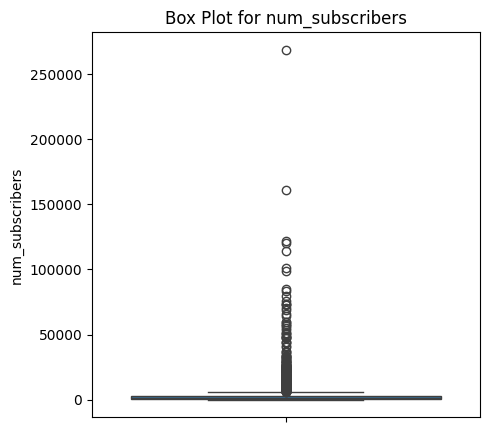

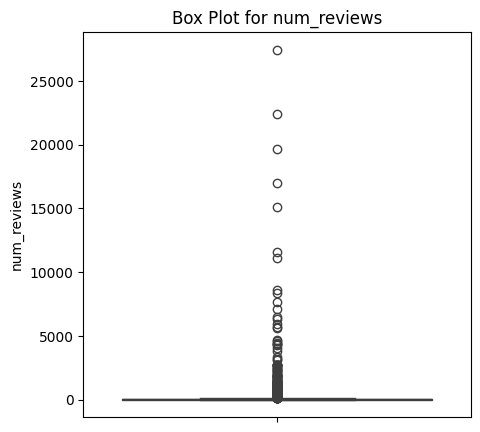

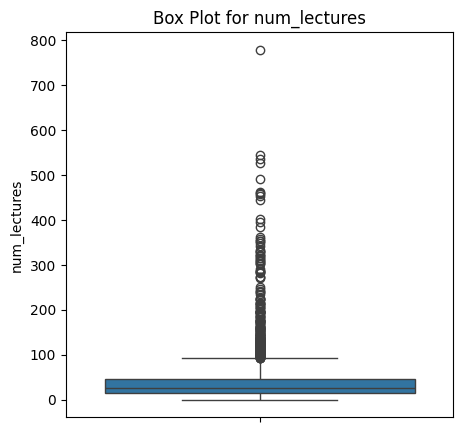

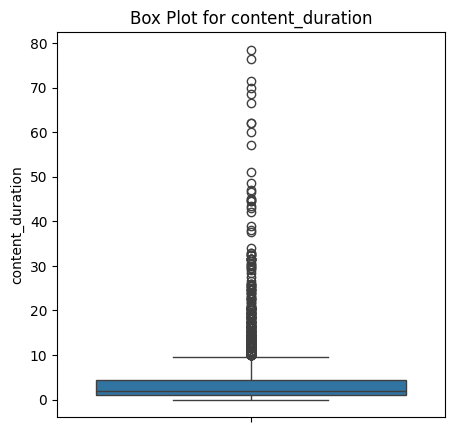

In [78]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=df[column])  
    plt.title(f'Box Plot for {column}')
    plt.ylabel(column)
    plt.show()

In [79]:
df_outliers_num_subs = pd.read_csv('outliers_num_subscribers.csv')
outliers_num_subs = df_outliers_num_subs[(df_outliers_num_subs["subject"]) != "Web Development"]
print(outliers_num_subs["course_id"].count())

df_outliers_content_duration = pd.read_csv('outliers_content_duration.csv')
noutliers_content_duration = df_outliers_content_duration[(df_outliers_content_duration["content_duration"]) >= 40]
print(noutliers_content_duration["course_id"].count())

df_outliers_num_lectures= pd.read_csv('outliers_num_lectures.csv')	
outliers_num_lectures = df_outliers_num_lectures[(df_outliers_num_lectures["num_lectures"]) >= 400]
print(outliers_num_lectures["course_id"].count())

df_outliers_num_reviews = pd.read_csv('outliers_num_reviews.csv')
outliers_num_reviews = df_outliers_num_reviews[
    (df_outliers_num_reviews["num_reviews"] >= 10000) | (df_outliers_num_reviews["subject"] != "Web Development")]
print(outliers_num_reviews["course_id"].count())



# Concatenate all outliers and drop duplicates
all_outliers = pd.concat([outliers_num_subs, noutliers_content_duration, outliers_num_lectures, outliers_num_reviews]).drop_duplicates(subset="course_id")
print(all_outliers["course_id"].count())
# Check how many outliers are being identified
print("Number of unique outliers identified:", len(all_outliers["course_id"].unique()))

# Check if the outliers match the expected number of rows to be removed
print("Total number of rows before removing outliers:", len(df))
print("Number of rows to remove:", len(all_outliers))

# Remove outliers from df
df_no_outliers_udemy = df[~df["course_id"].isin(all_outliers["course_id"])]
print("Number of rows after removing outliers:", len(df_no_outliers_udemy))






12
21
11
9
42
Number of unique outliers identified: 42
Total number of rows before removing outliers: 3672
Number of rows to remove: 42
Number of rows after removing outliers: 3630


BOX 7 Perform a Chi-Square Test for Goodness of Fit on observed categorical counts.

In [80]:
def chi_square_test(observed_values, alpha=0.05):

    expected_counts = [sum(observed_values) / len(observed_values)] * len(observed_values)

    chi2_stat, p_value = chisquare(f_obs=observed_values, f_exp=expected_counts)

    result = "reject the null hypothesis" if p_value < alpha else "fail to reject the null hypothesis"
    
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")

    # print(f"Observed Values: {observed_values}")
    # print(f"Expected Values: {expected_counts}")
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")
    
    return {
        f"Chi-Square Statistic: {chi2_stat}",
        f"P-Value: {p_value}",
        f"Result: {result}"
    }

In [81]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


Histogram with outliers

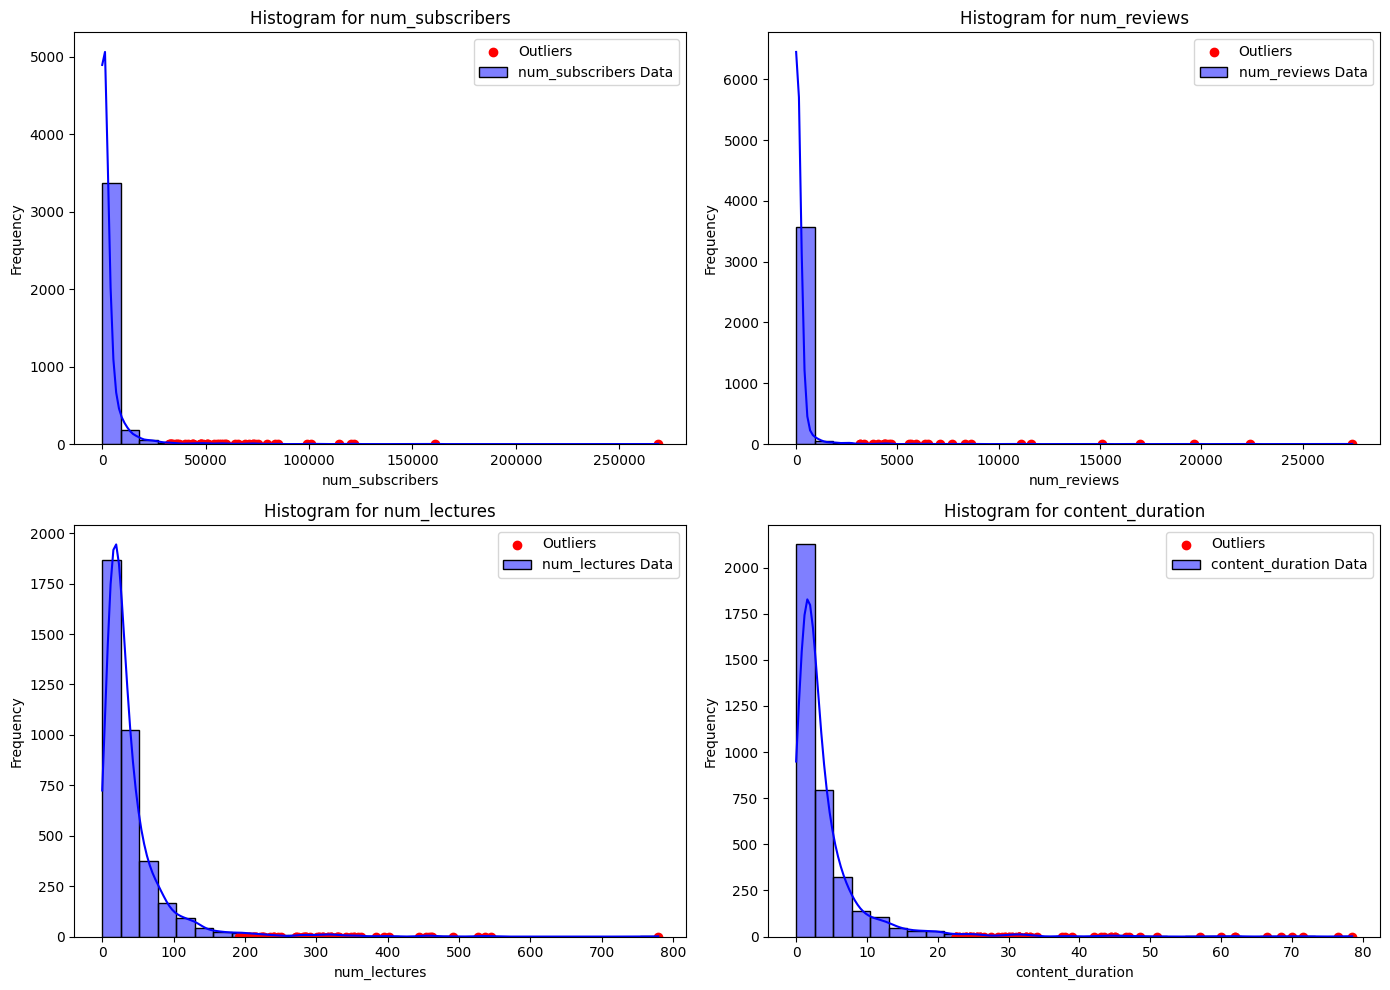

In [82]:
# List of independent variables to plot
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Set up the plot size
plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  # Create subplots in a 2x2 grid

    # Plot the histogram for the current variable
    sns.histplot(df[var], kde=True, color='blue', label=f'{var} Data', bins=30)

    # Highlight outliers (we assume outliers are already detected and stored in a variable like 'outliers_z_score')
    z_scores = np.abs((df[var] - df[var].mean()) / df[var].std())  # Z-score for current variable
    outliers_z_score = df[z_scores > 3]

    # Plot outliers in red on the histogram
    plt.scatter(outliers_z_score[var], np.zeros_like(outliers_z_score[var]), color='red', label='Outliers')

    # Add titles and labels
    plt.title(f'Histogram for {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  # Adjust the layout to fit all subplots
plt.show()


    


Histogram for all independent variables without outliers

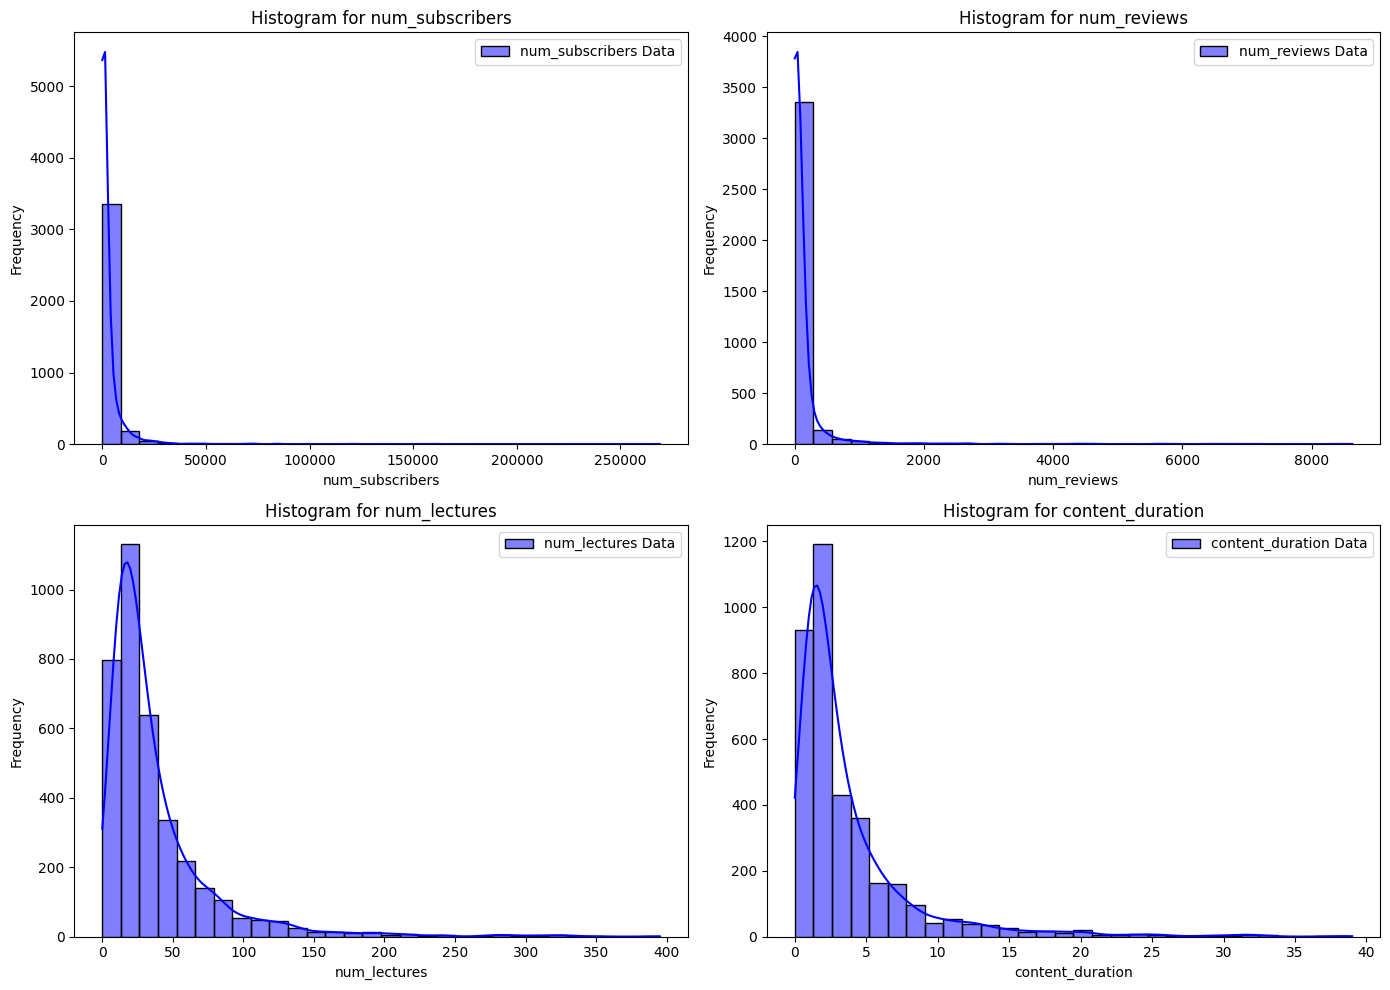

In [83]:
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  


    sns.histplot(df_no_outliers_udemy[var], kde=True, color='blue', label=f'{var} Data', bins=30)
    
    plt.title(f'Histogram for {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  
plt.show()


    


Histogram only for web dev courses without outliers

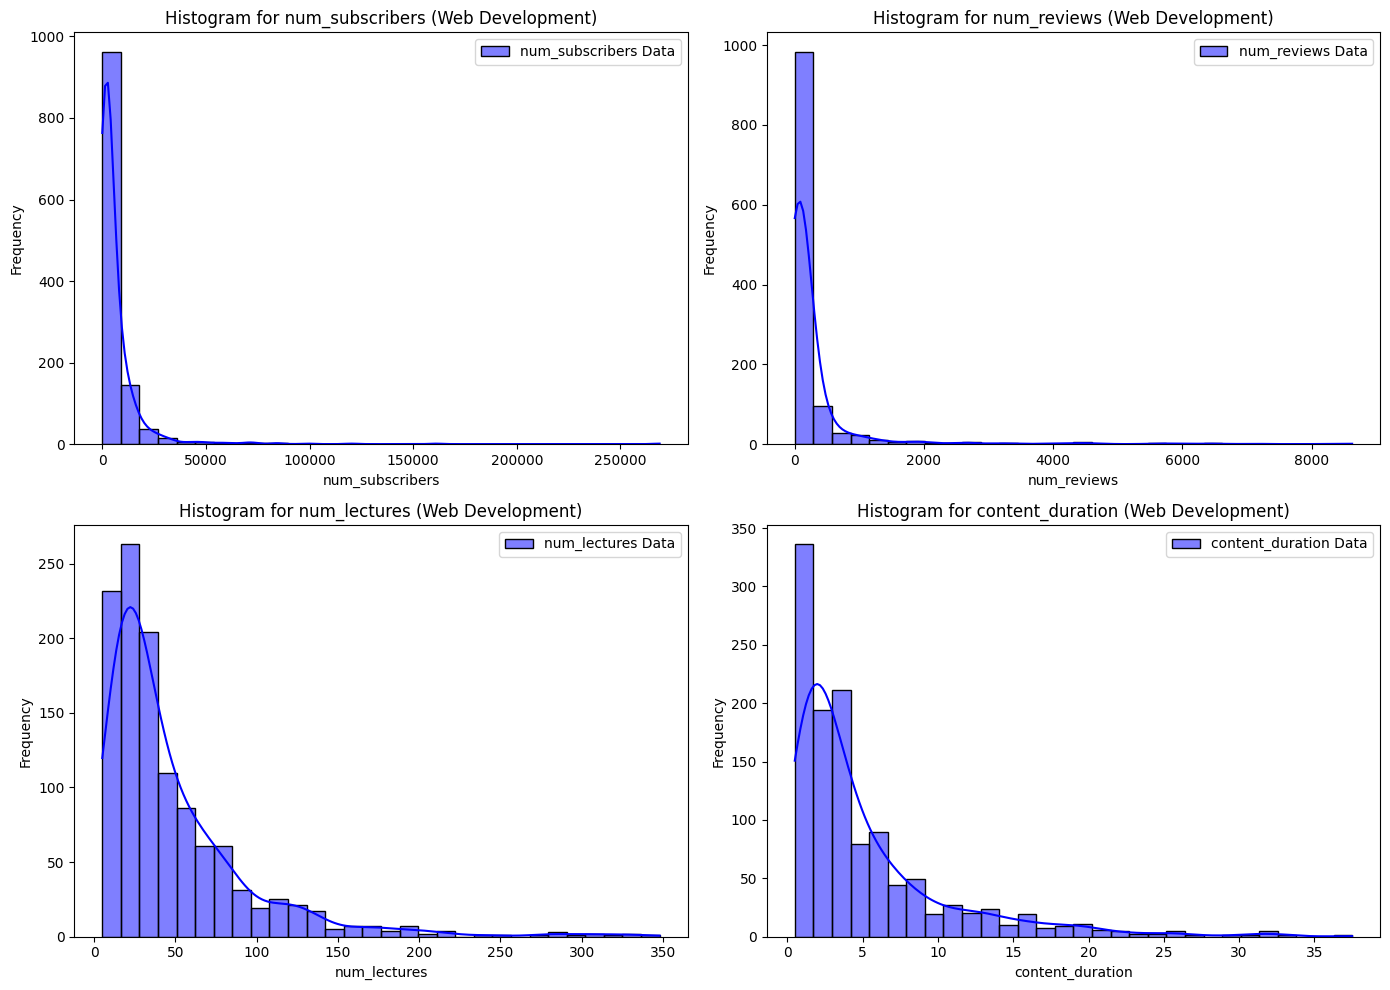

In [84]:
# Filter data for Web Development courses
web_dev_courses = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  

    # Create histogram for Web Development courses only
    sns.histplot(web_dev_courses[var], kde=True, color='blue', label=f'{var} Data', bins=30)
    
    plt.title(f'Histogram for {var} (Web Development)')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  
plt.show()


histogram for web dev courses without outliers by levels

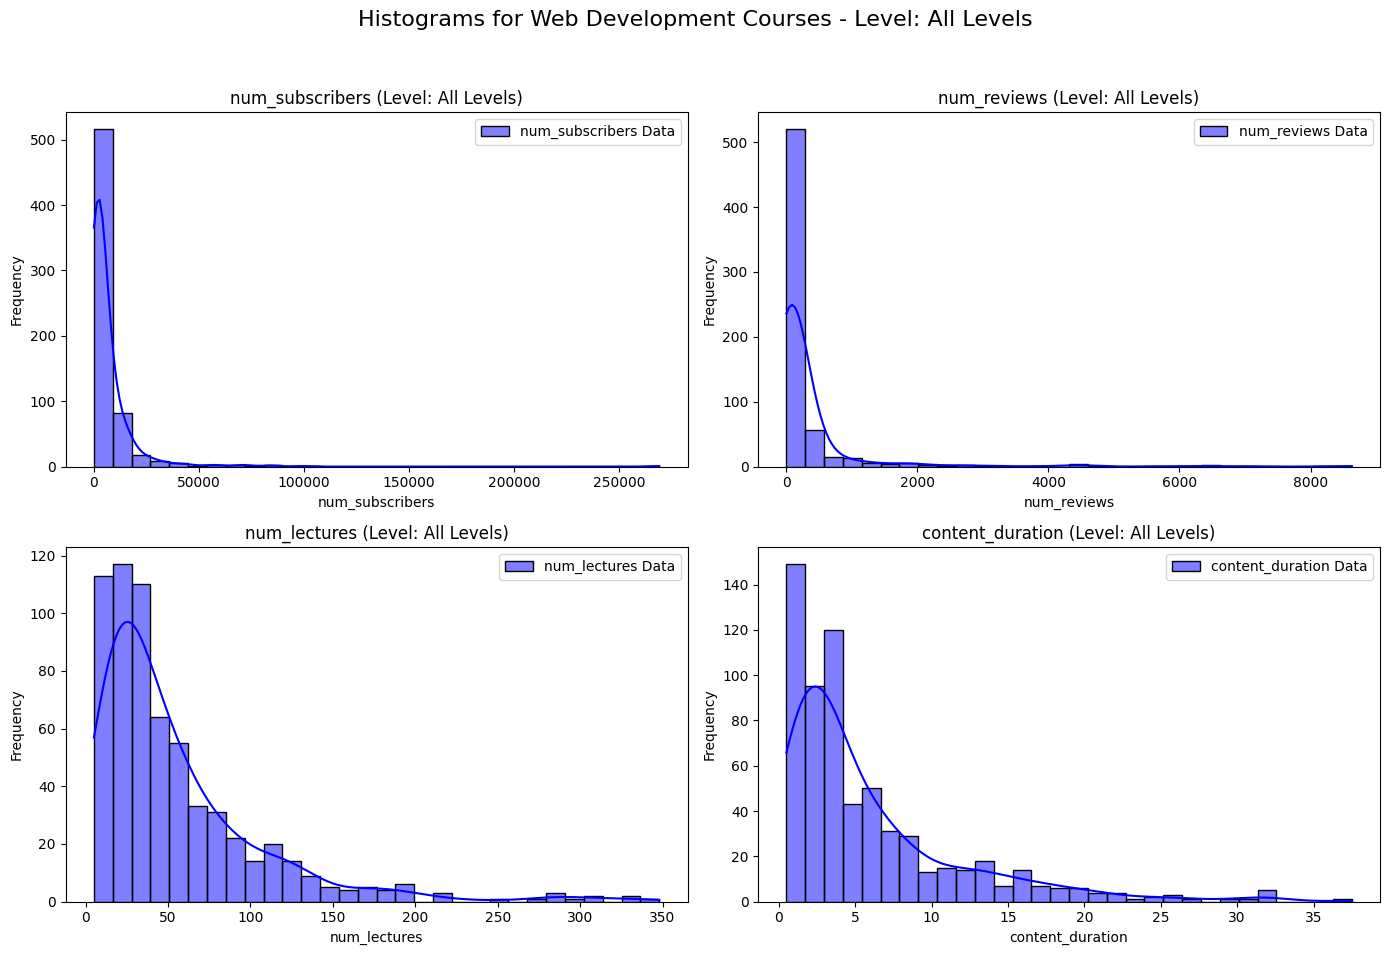

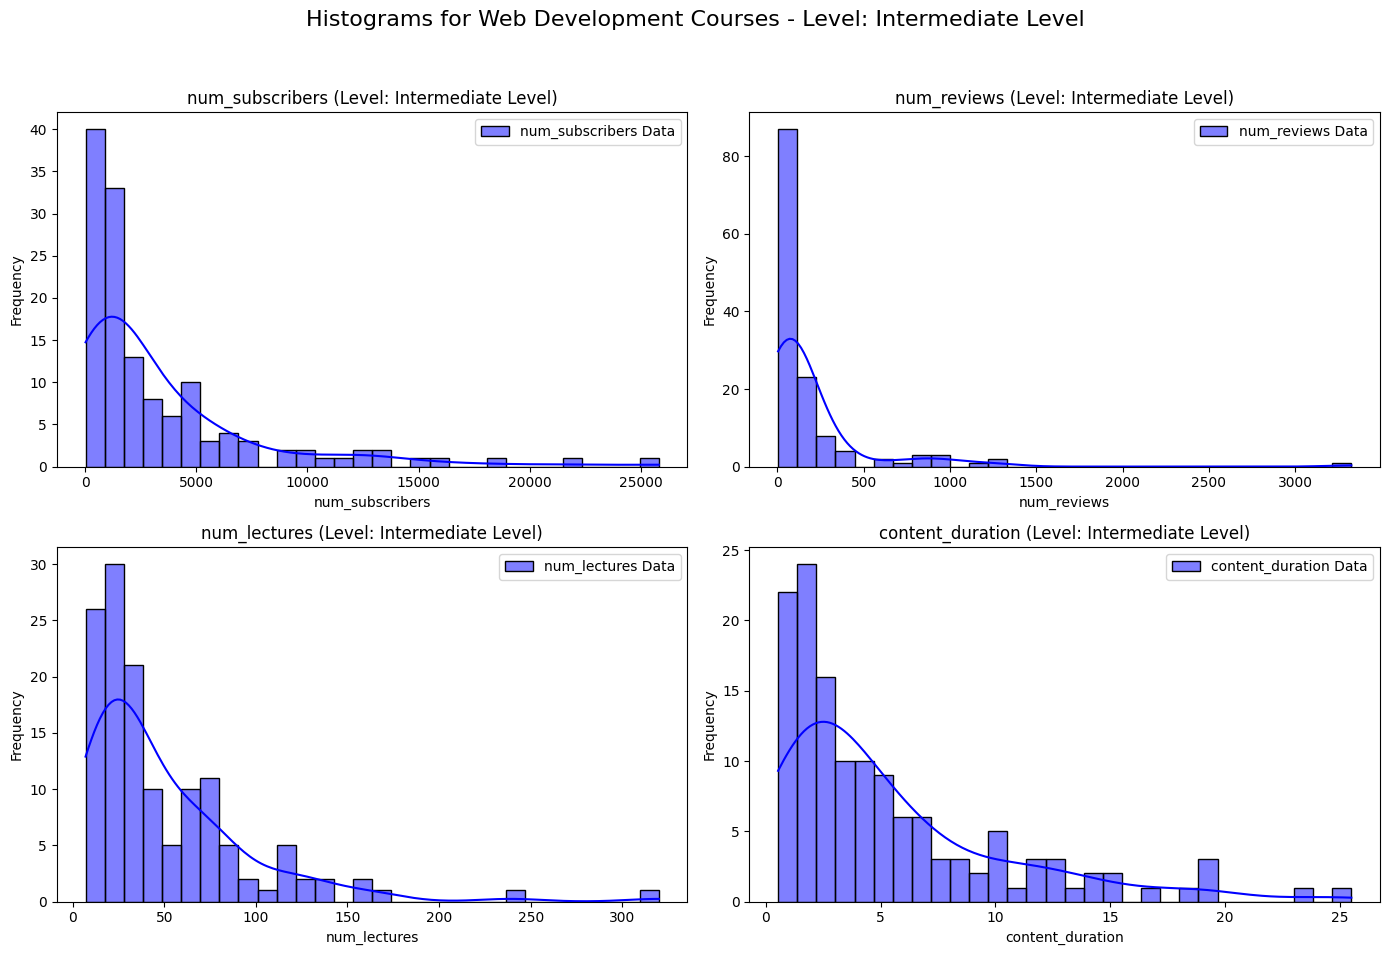

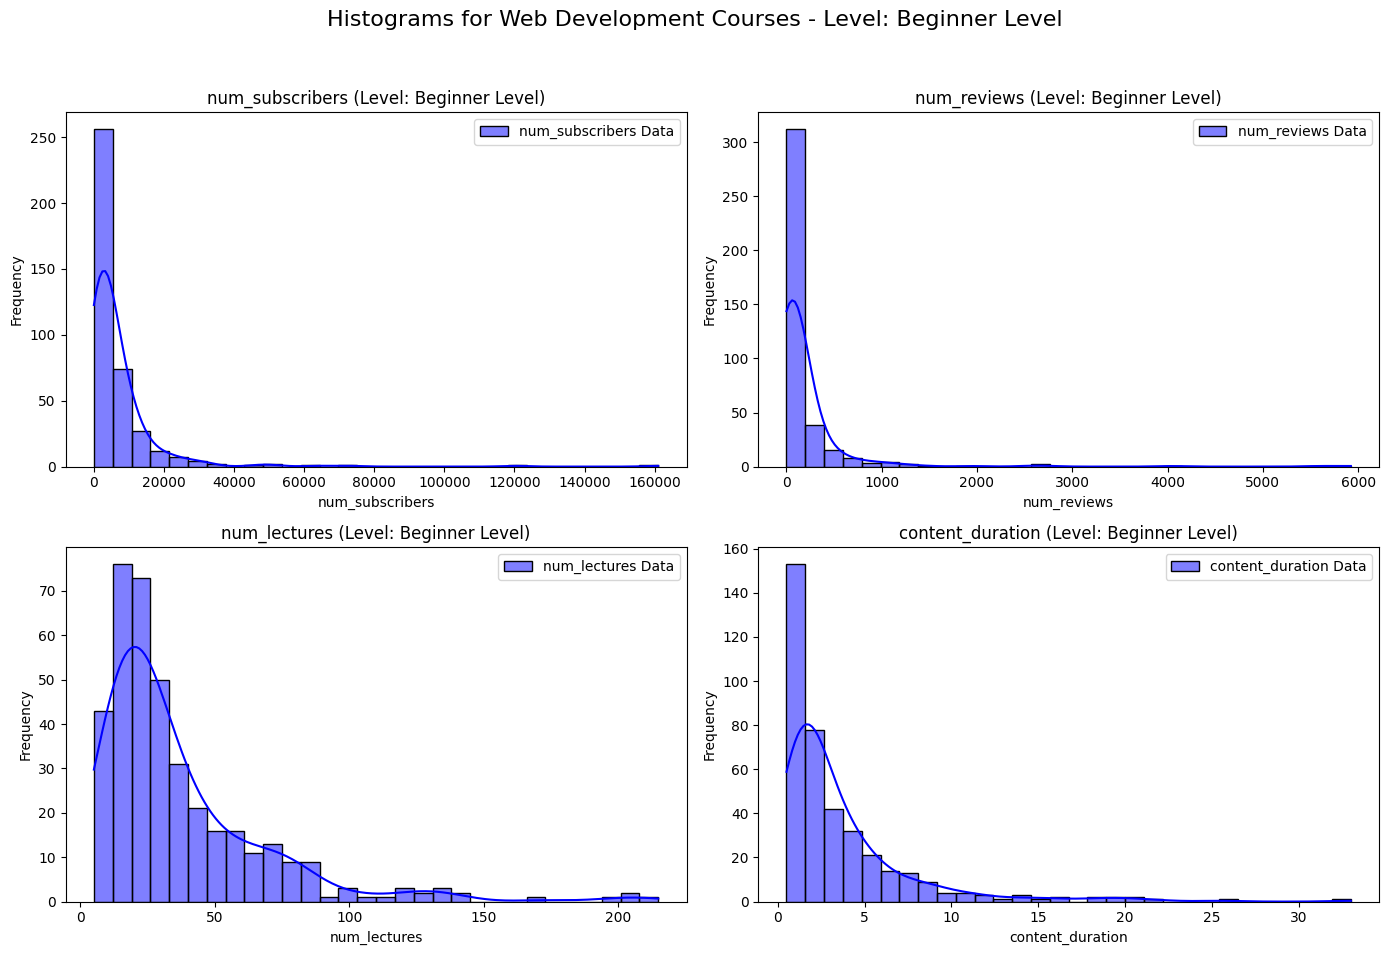

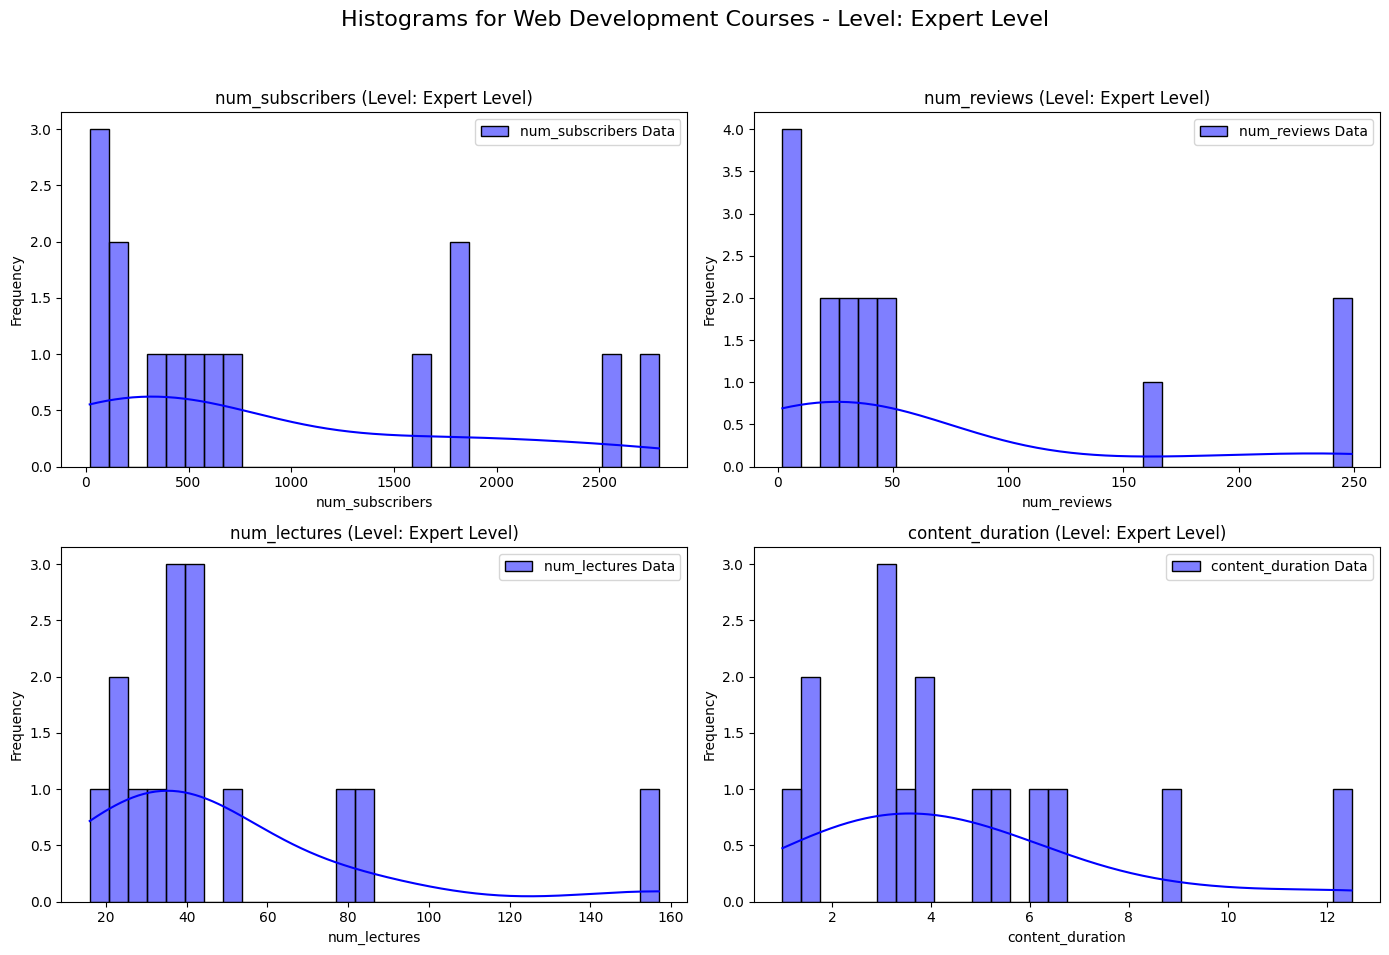

In [85]:
# Filter data for Web Development courses
web_dev_courses = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# List of independent variables
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Unique levels in the 'level' column
lecture_levels = web_dev_courses['level'].unique()

# Create histograms grouped by lecture level
for level in lecture_levels:
    level_data = web_dev_courses[web_dev_courses['level'] == level]
    plt.figure(figsize=(14, 10))
    plt.suptitle(f'Histograms for Web Development Courses - Level: {level}', fontsize=16)
    
    for i, var in enumerate(independent_vars, 1):
        plt.subplot(2, 2, i)

        sns.histplot(level_data[var], kde=True, color='blue', label=f'{var} Data', bins=30)
        
        plt.title(f'{var} (Level: {level})')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
    plt.show()


Mean Squared Error: 3299.587562441589
R-squared: 0.10231354991737096

Lasso Coefficients:
            Feature  Coefficient
0   num_subscribers    -2.283554
1       num_reviews     3.155279
2      num_lectures    14.527576
3  content_duration     6.430394


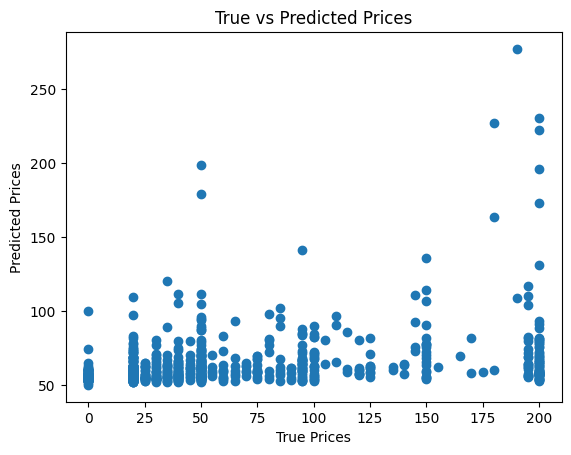

In [86]:
X = df[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']]  
y = df['price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.1)  
lasso.fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("\nLasso Coefficients:")
print(coefficients)

plt.scatter(y_test, y_pred)
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("True vs Predicted Prices")
plt.show()


BOX 8 BARCHART: count all the courses taking into account the subject

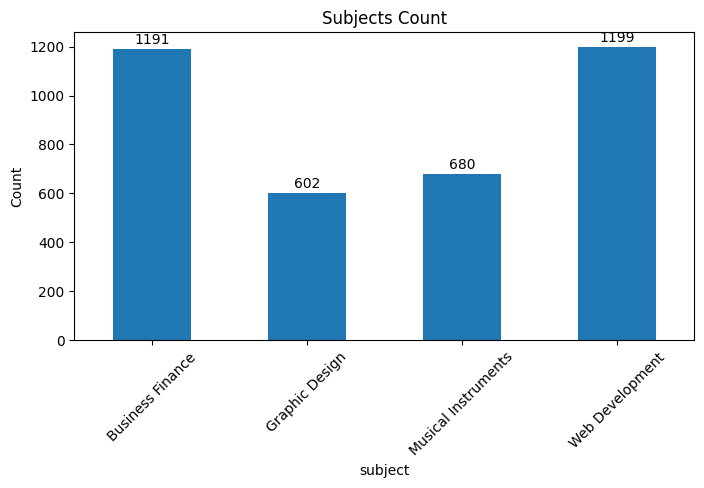

In [87]:
category = df.groupby('subject')['subject'].count()

plt.figure(figsize=(8, 4))
for i, v in enumerate(category.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
category.plot(kind='bar')
plt.title('Subjects Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

BOX 9: Chi square for courses based on subj
H₀: There is no statistical difference in the number of couses per subject
H₁: There is a statistical difference in the number of couses per subject for at least one subject

In [88]:
observed_cat = category.values  
chi_square_test(observed_cat)

{'Chi-Square Statistic: 337.67973856209153',
 'P-Value: 6.938242224702548e-73',
 'Result: reject the null hypothesis'}

BOX 10 BARCHART: avg duration per subject

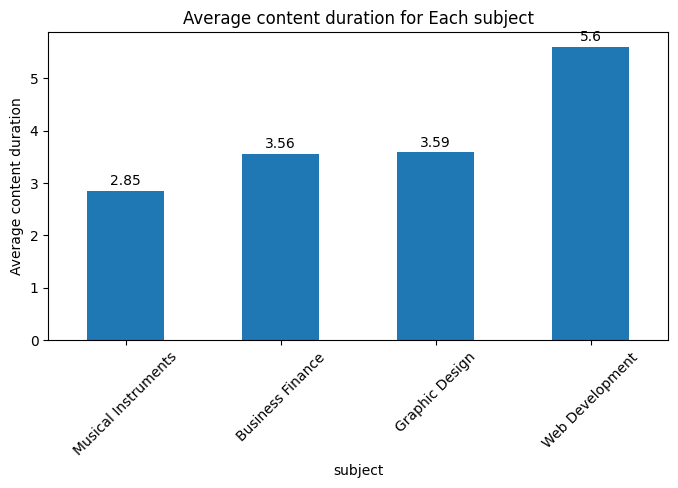

In [89]:
avg_duration_subj = df.groupby('subject')['content_duration'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_duration_subj.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_duration_subj.plot(kind='bar')
plt.title('Average content duration for Each subject')
plt.xlabel('subject')
plt.ylabel('Average content duration')
plt.xticks(rotation=45)
plt.show()

BOX 11 Chi Square for avr duration based on each subject
H₀: all subjects have a similar value for the avg duration 
H₁: at least one subject has a different value for the avg duration

In [90]:
observed_avg_duration = avg_duration_subj.values
chi_square_test(observed_avg_duration)

{'Chi-Square Statistic: 1.0738276876778154',
 'P-Value: 0.7833956419700129',
 'Result: fail to reject the null hypothesis'}

BOX 12 BARCHART: total number of subscribers enrolled for each subject

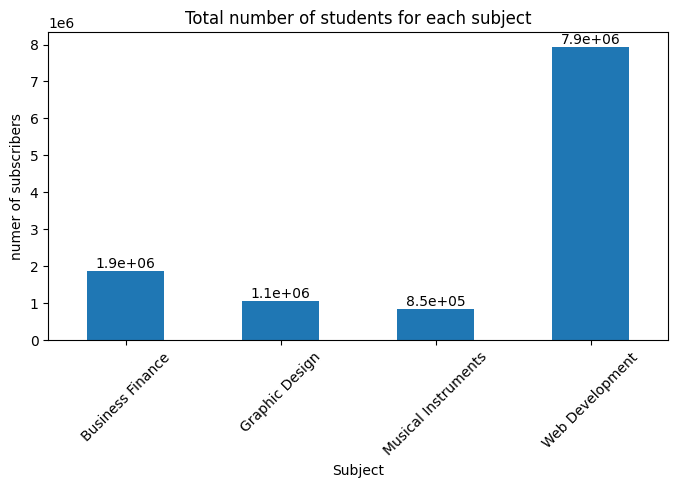

In [91]:
total_enrolled_stud = df.groupby('subject')['num_subscribers'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_enrolled_stud.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_enrolled_stud.plot(kind='bar')
plt.title('Total number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

BOX 13 Chi Square for total number of subscribers enrolled in each subject
H₀: all subjects have a similar number of students enrolled
H₁: at least one subject has a different number of students enrolled

In [92]:
observed_total_subscribers = total_enrolled_stud.values
chi_square_test(observed_total_subscribers)

{'Chi-Square Statistic: 11616610.926223781',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

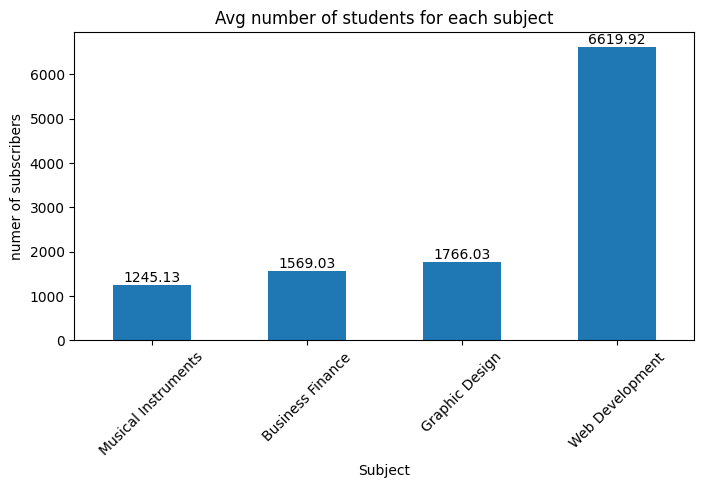

In [93]:
avg_enrolled_stud = df.groupby('subject')['num_subscribers'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4))

for i, v in enumerate(avg_enrolled_stud.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')

avg_enrolled_stud.plot(kind='bar')
plt.title('Avg number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

BOX 14 BARCHART: total number of reviews for each subject

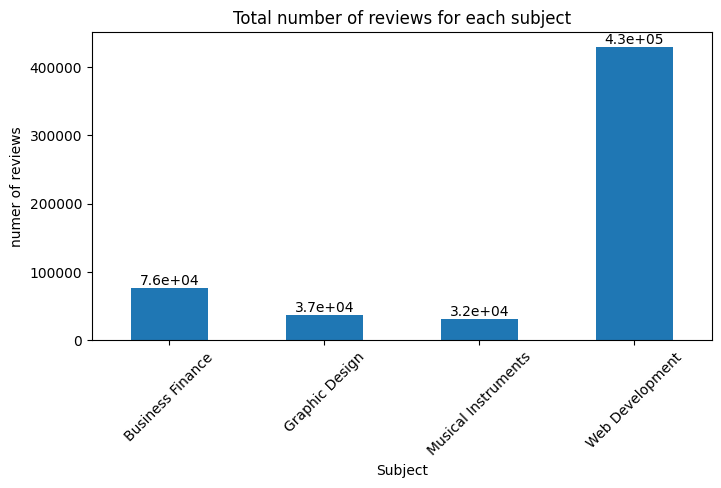

In [94]:
total_reviews = df.groupby('subject')['num_reviews'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_reviews.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_reviews.plot(kind='bar')
plt.title('Total number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

BOX 15: Chi Square test for total number of reviews
H0: The is no significant difference in the number of reviews across all subjects
H1: At least one subject has a different number of reviews that others

In [95]:
observed_total_reviews = total_reviews.values
chi_square_test(observed_total_reviews)

{'Chi-Square Statistic: 767589.4577879331',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

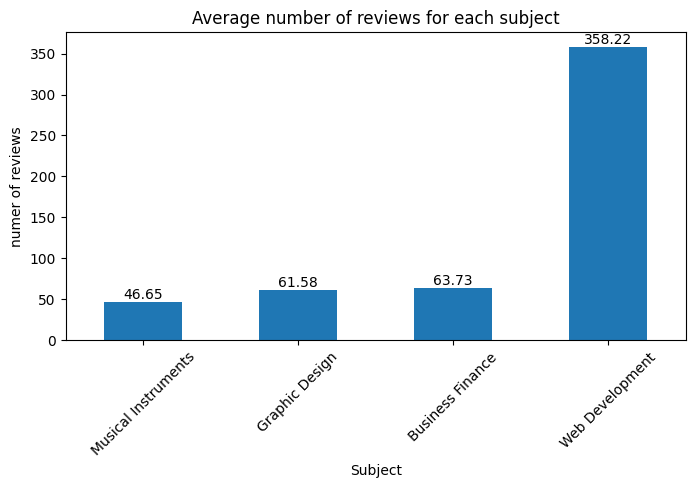

In [96]:
avg_reviews = df.groupby('subject')['num_reviews'].mean().sort_values(ascending=True)



plt.figure(figsize=(8, 4))

for i, v in enumerate(avg_reviews.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')

avg_reviews.plot(kind='bar')
plt.title('Average number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

BOX 16 BARCHART: total number of professors for each subject

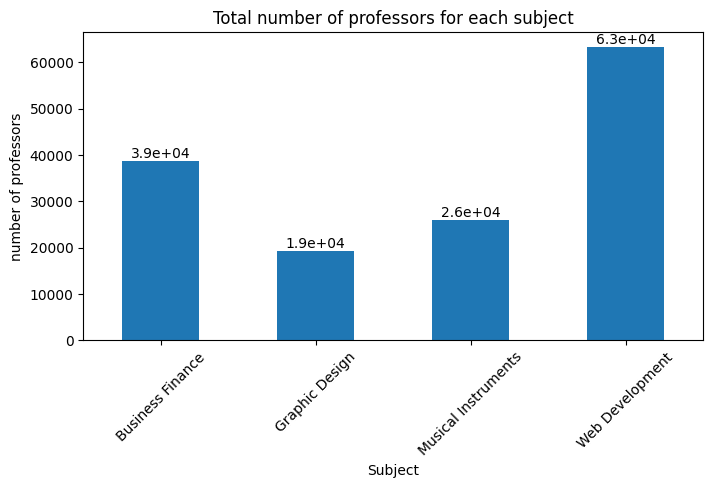

In [97]:
total_professors = df.groupby('subject')['num_lectures'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_professors.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_professors.plot(kind='bar')
plt.title('Total number of professors for each subject')
plt.xlabel('Subject')
plt.ylabel('number of professors')
plt.xticks(rotation=45)
plt.show()

BOX 17: Chi Square for number of professors
H0: There is no statistical difference between the number of professors per subject
H1: At last one subject has a different number of professors than the others

In [98]:
observed_total_professors= total_professors.values
chi_square_test(observed_total_professors)

{'Chi-Square Statistic: 30658.86730893178',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 18 BARCHART: avg prices for each subject

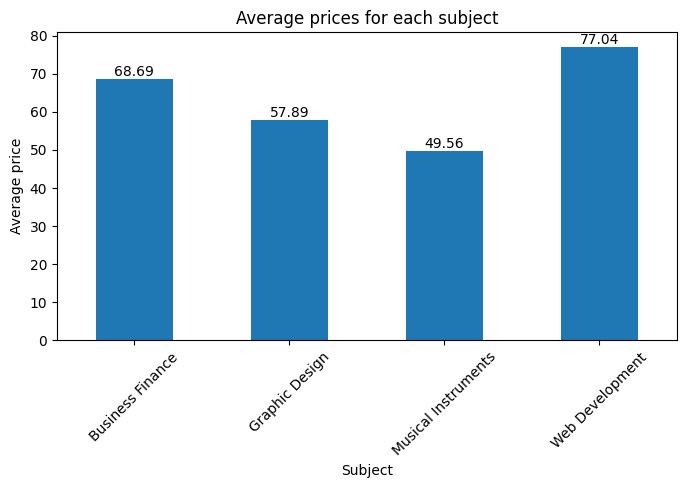

In [99]:
avg_price = df.groupby('subject')['price'].mean()

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_price.values):
    plt.text(i, round(v,2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_price.plot(kind='bar')
plt.title('Average prices for each subject')
plt.xlabel('Subject')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.show()

BOX 19: Chi Square test for avg prices per subject
H0: There is no statistical difference between the avg price per subject
H1: At last one subject has a different agv price than the others

In [100]:
observed_avg_price = avg_price.values
chi_square_test(observed_avg_price)

{'Chi-Square Statistic: 6.88579963278157',
 'P-Value: 0.07562818840722958',
 'Result: fail to reject the null hypothesis'}

BOX 20: Checking price values over time for every category

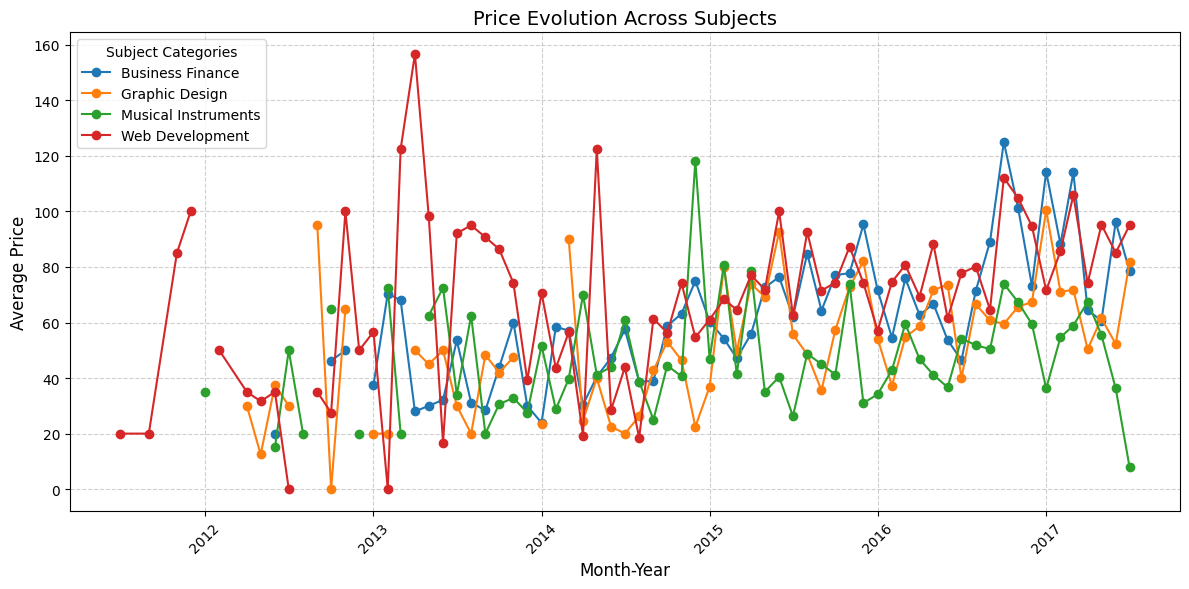

In [101]:
df["published_timestamp"] = pd.to_datetime(df["published_timestamp"])
df["Month-Year"] = df["published_timestamp"].dt.strftime("%b-%Y")

grouped = df.groupby(["subject", "Month-Year"], as_index=False)["price"].mean()

pivoted = grouped.pivot(index="Month-Year", columns="subject", values="price")

pivoted.index = pd.to_datetime(pivoted.index, format="%b-%Y")
pivoted = pivoted.sort_index()

plt.figure(figsize=(12, 6))
for category in pivoted.columns:
    plt.plot(pivoted.index, pivoted[category], marker="o", label=category)

plt.title("Price Evolution Across Subjects", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.legend(title="Subject Categories")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

BOX 21: Avg price per subject taking into account all categories

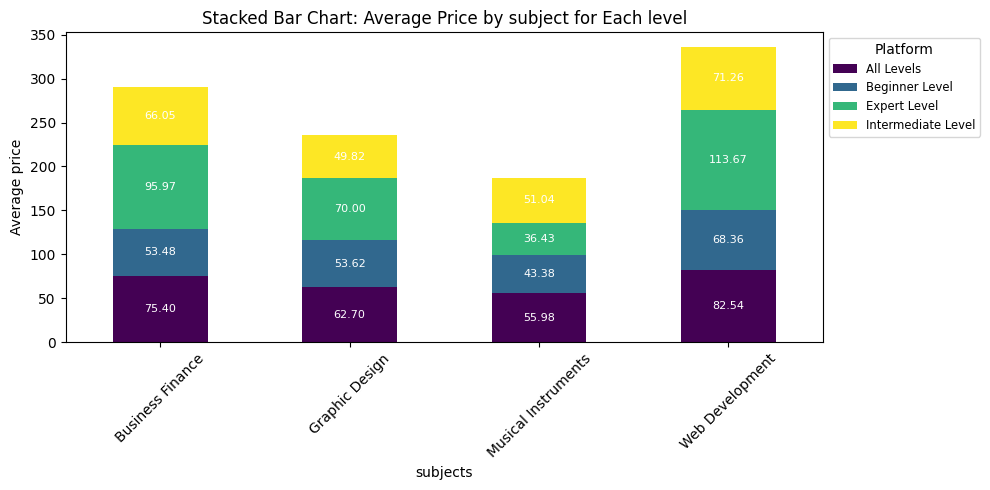

In [102]:
avg_price_per_category = df.groupby(['subject', 'level'])['price'].mean().unstack()

ax = avg_price_per_category.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    colormap='viridis'
)


for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        if bar.get_height() > 0:  
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                bar.get_y() + height / 2,          
                f'{height:.2f}',                   
                ha='center', va='center', fontsize=8, color='white'
            )

plt.title('Stacked Bar Chart: Average Price by subject for Each level')
plt.xlabel('subjects')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.legend(title='Platform', fontsize='small', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

plt.show()

BOX 20: Checking distribution for price

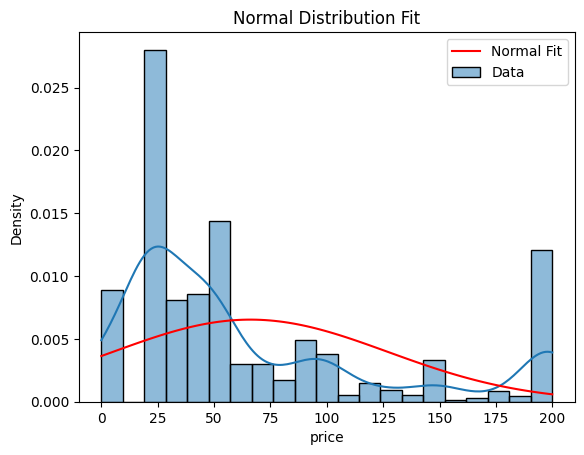

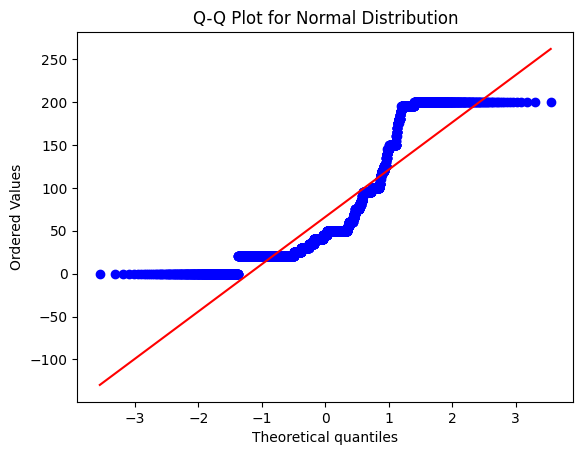

Shapiro-Wilk Test: Stat=0.8125917569824538, p=2.8372585758096045e-54
Data does not follow a normal distribution.


In [103]:
prices = df['price']

sns.histplot(prices, kde=True, stat='density', label='Data')
mean, std = prices.mean(), prices.std()
x = np.linspace(prices.min(), prices.max(), 100)
plt.plot(x, stats.norm.pdf(x, mean, std), label='Normal Fit', color='red')
plt.title('Normal Distribution Fit')
plt.legend()
plt.show()

stats.probplot(prices, dist="norm", plot=plt)
plt.title('Q-Q Plot for Normal Distribution')
plt.show()

stat, p = stats.shapiro(prices)
print(f'Shapiro-Wilk Test: Stat={stat}, p={p}')
if p > 0.05:
    print("Data follows a normal distribution.")
else:
    print("Data does not follow a normal distribution.")


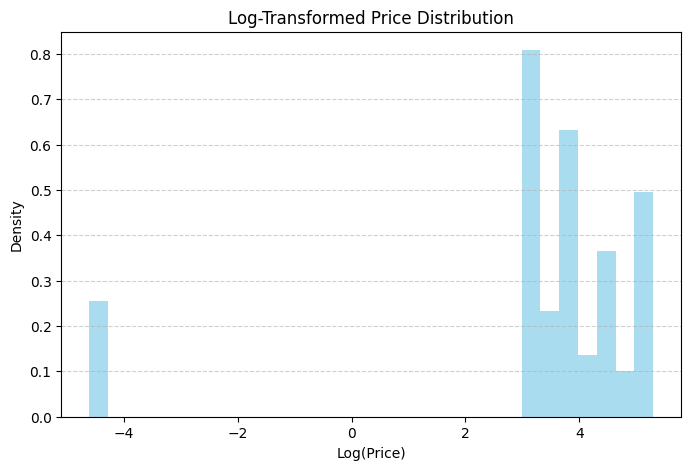

In [104]:
df['price_log'] = np.log(df['price'].replace(0, 0.01))

# Plot the transformed distribution
plt.figure(figsize=(8, 5))
plt.hist(df['price_log'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


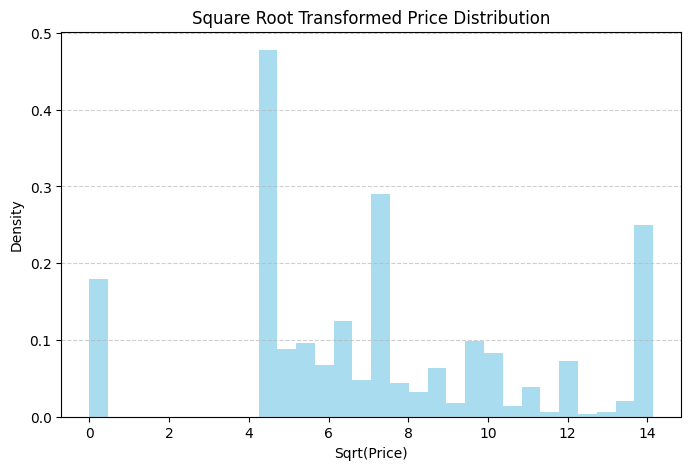

In [105]:
df['price_sqrt'] = np.sqrt(df['price'])

plt.figure(figsize=(8, 5))
plt.hist(df['price_sqrt'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Square Root Transformed Price Distribution')
plt.xlabel('Sqrt(Price)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

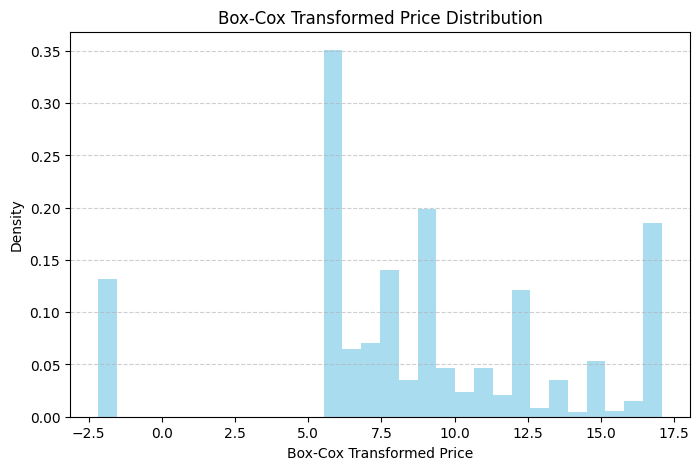

In [106]:
from scipy.stats import boxcox

# Ensure no zero prices by replacing zero with a small value
df['price_adjusted'] = df['price'].replace(0, 0.01)

# Apply Box-Cox transformation
df['price_boxcox'], lambda_ = boxcox(df['price_adjusted'])

# Plot the transformed distribution
plt.figure(figsize=(8, 5))
plt.hist(df['price_boxcox'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Box-Cox Transformed Price Distribution')
plt.xlabel('Box-Cox Transformed Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


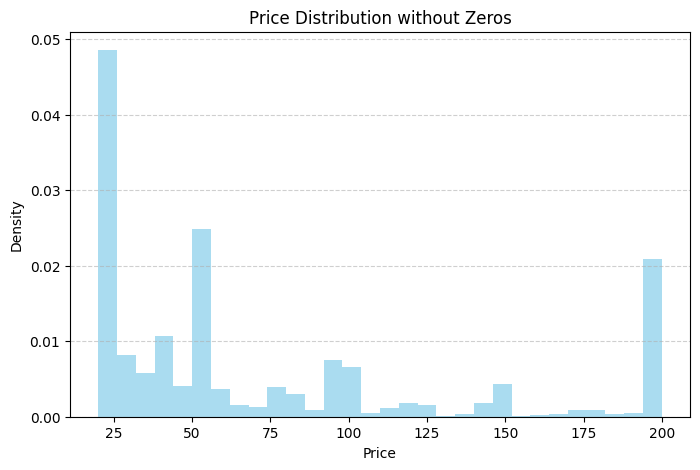

Shapiro-Wilk Test: Stat = 0.7862613045584798, p-value = 7.020117445293386e-55


In [107]:
# Remove rows where price is zero
df_non_zero_price = df[df['price'] > 0]

# Plot the original distribution without zeros
plt.figure(figsize=(8, 5))
plt.hist(df_non_zero_price['price'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Price Distribution without Zeros')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

from scipy import stats

# Shapiro-Wilk Test for normality
stat, p_value = stats.shapiro(df_non_zero_price['price'])
print(f"Shapiro-Wilk Test: Stat = {stat}, p-value = {p_value}")



In [108]:
# params = stats.expon.fit(prices)  
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.expon.pdf(x, *params), label='Exponential Fit', color='green')
# plt.title('Exponential Distribution Fit')
# plt.legend()
# plt.show()

# stats.probplot(prices, dist="expon", sparams=params, plot=plt)
# plt.title('Q-Q Plot for Exponential Distribution')
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'expon', args=params)
# print(f'KS Test for Exponential: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows an exponential distribution.")
# else:
#     print("Data does not follow an exponential distribution.")

In [109]:
# log_prices = np.log1p(prices)  # log(1+x) to handle zeros
# sns.histplot(log_prices, kde=True, stat='density', label='Log Data')
# plt.title('Logarithmic Distribution Fit')
# plt.legend()
# plt.show()

# # Q-Q Plot
# stats.probplot(log_prices, dist="norm", plot=plt)
# plt.title('Q-Q Plot for Logarithmic Distribution')
# plt.show()

# # Shapiro-Wilk Test
# stat, p = stats.shapiro(log_prices)
# print(f'Shapiro-Wilk Test on Log Transformed Data: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Log-transformed data follows a normal distribution.")
# else:
#     print("Log-transformed data does not follow a normal distribution.")

In [110]:
# # Fit Gamma Distribution
# params = stats.gamma.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.gamma.pdf(x, *params), label='Gamma Fit', color='purple')
# plt.title('Gamma Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'gamma', args=params)
# print(f'KS Test for Gamma: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a gamma distribution.")
# else:
#     print("Data does not follow a gamma distribution.")


In [111]:
# # Fit Weibull Distribution
# params = stats.weibull_min.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.weibull_min.pdf(x, *params), label='Weibull Fit', color='orange')
# plt.title('Weibull Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'weibull_min', args=params)
# print(f'KS Test for Weibull: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a Weibull distribution.")
# else:
#     print("Data does not follow a Weibull distribution.")


In [112]:
# # Normalize data to fit [0, 1]
# normalized_prices = (prices - prices.min()) / (prices.max() - prices.min())

# # Fit Beta Distribution
# params = stats.beta.fit(normalized_prices)
# sns.histplot(normalized_prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.beta.pdf(x, *params), label='Beta Fit', color='green')
# plt.title('Beta Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(normalized_prices, 'beta', args=params)
# print(f'KS Test for Beta: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a beta distribution.")
# else:
#     print("Data does not follow a beta distribution.")


In [113]:
# # Fit Log-Normal Distribution
# params = stats.lognorm.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.lognorm.pdf(x, *params), label='Log-Normal Fit', color='blue')
# plt.title('Log-Normal Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'lognorm', args=params)
# print(f'KS Test for Log-Normal: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a log-normal distribution.")
# else:
#     print("Data does not follow a log-normal distribution.")


In [114]:
# # Fit Chi-Square Distribution
# params = stats.chi2.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.chi2.pdf(x, *params), label='Chi-Square Fit', color='brown')
# plt.title('Chi-Square Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'chi2', args=params)
# print(f'KS Test for Chi-Square: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a chi-square distribution.")
# else:
#     print("Data does not follow a chi-square distribution.")


In [115]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust n_components as needed
# gmm.fit(prices.values.reshape(-1, 1))
# sns.histplot(prices, kde=False, stat="density", label="Data")
# x = np.linspace(prices.min(), prices.max(), 1000).reshape(-1, 1)
# pdf = np.exp(gmm.score_samples(x))
# plt.plot(x, pdf, label="GMM Fit", color="red")
# plt.title("Gaussian Mixture Model Fit")
# plt.legend()
# plt.show()


In [116]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# # Empirical data (price)
# data = prices

# # Histogram for empirical density
# counts, bin_edges = np.histogram(data, bins=20, density=True)
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# # Fit a distribution (e.g., Normal)
# dist_name = 'norm'  # Change to other distributions like 'expon', 'gamma'
# params = getattr(stats, dist_name).fit(data)
# pdf_fitted = getattr(stats, dist_name).pdf(bin_centers, *params)

# # Calculate RMSE
# rmse = np.sqrt(np.mean((counts - pdf_fitted) ** 2))

# # Plot for visualization
# plt.hist(data, bins=20, density=True, alpha=0.5, label="Empirical Data")
# plt.plot(bin_centers, pdf_fitted, label=f"{dist_name.capitalize()} Fit", color="red")
# plt.title(f"{dist_name.capitalize()} Distribution Fit (RMSE: {rmse:.4f})")
# plt.xlabel("Price")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

# print(f"RMSE for {dist_name.capitalize()} distribution: {rmse:.4f}")


BOX 20: checking normal distibutions

In [117]:
# for column in df.select_dtypes(include=['float64', 'int64']).columns:
#     print(f"\nAnalyzing {column}:")

#     plt.figure(figsize=(12, 6))
#     sns.histplot(df[column].dropna(), kde=True, stat="density", color="skyblue", label="Data Density")
 
#     mean, std = norm.fit(df[column].dropna()) 
#     x = np.linspace(df[column].min(), df[column].max(), 100)
#     p = norm.pdf(x, mean, std)
#     plt.plot(x, p, 'r--', label="Normal Fit")
#     plt.title(f"Histogram with Normal Fit for {column}")
#     plt.legend()
#     plt.show()

#     plt.figure(figsize=(6, 6))
#     from scipy.stats import probplot
#     probplot(df[column].dropna(), dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot for {column}")
#     plt.show()

#     stat, p_value = shapiro(df[column].dropna())
#     print(f"Shapiro-Wilk Test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}")
    
#     if p_value < 0.05:
#         print(f"{column} does NOT follow a normal distribution.")
#     else:
#         print(f"{column} follows a normal distribution.")

RELATIONSHIP BETWEEN VARIABLES

BOX 1: COVARIANCE MATRIX

In [118]:
numeric_columns = ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']
numeric_data = df[numeric_columns]

covariance_matrix = numeric_data.cov()

print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
                         price  num_subscribers   num_reviews  num_lectures  \
price              3725.383571     2.920833e+04  6.489357e+03   1015.321979   
num_subscribers   29208.332379     9.002415e+07  5.783174e+06  75749.221400   
num_reviews        6489.357284     5.783174e+06  8.764305e+05  11470.339062   
num_lectures       1015.321979     7.574922e+04  1.147034e+04   2541.884165   
content_duration    108.409322     9.318099e+03  1.297867e+03    244.830473   

                  content_duration  
price                   108.409322  
num_subscribers        9318.099228  
num_reviews            1297.867071  
num_lectures            244.830473  
content_duration         36.697302  


BOX 2 Correlation - spearman coeff

In [119]:
spearman_corr = numeric_data.corr(method='spearman')
print("Spearman Correlation Matrix:")
print(spearman_corr)

Spearman Correlation Matrix:
                     price  num_subscribers  num_reviews  num_lectures  \
price             1.000000         0.065417     0.142063      0.386509   
num_subscribers   0.065417         1.000000     0.784343      0.209673   
num_reviews       0.142063         0.784343     1.000000      0.341210   
num_lectures      0.386509         0.209673     0.341210      1.000000   
content_duration  0.352195         0.168231     0.322259      0.805391   

                  content_duration  
price                     0.352195  
num_subscribers           0.168231  
num_reviews               0.322259  
num_lectures              0.805391  
content_duration          1.000000  


BOX 3: the relationship between all numeric variables 2 by 2 

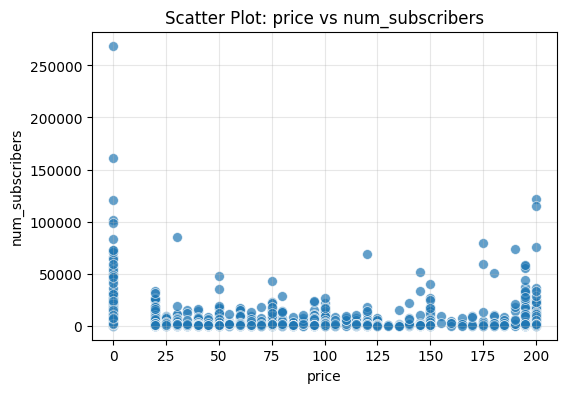

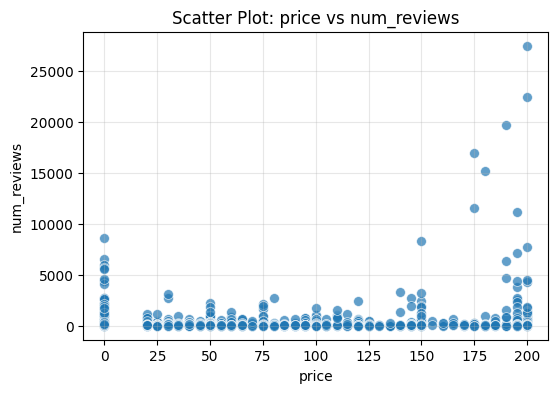

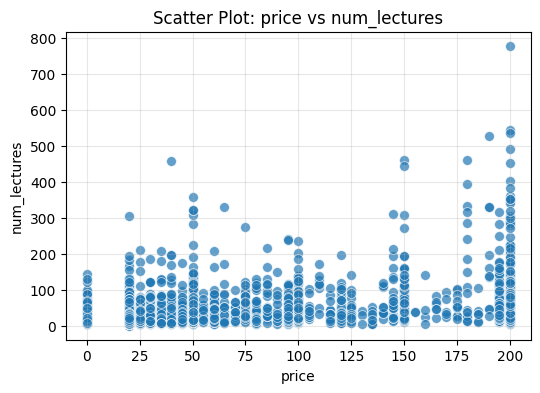

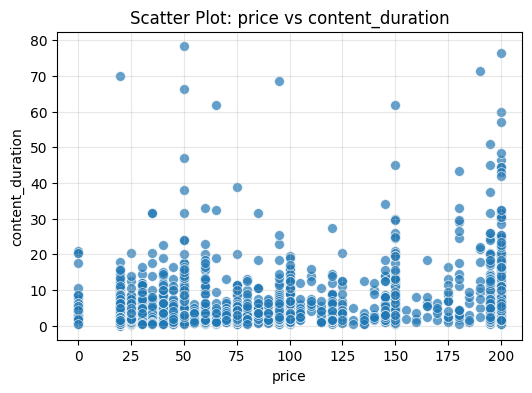

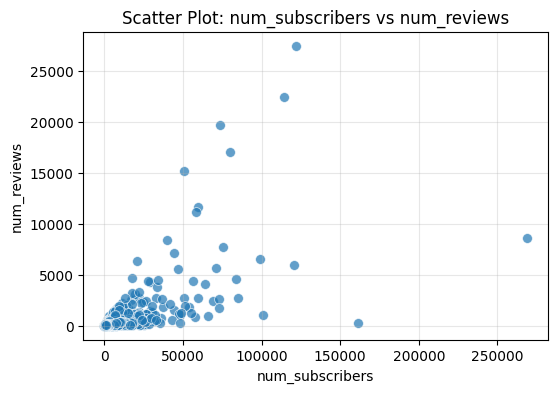

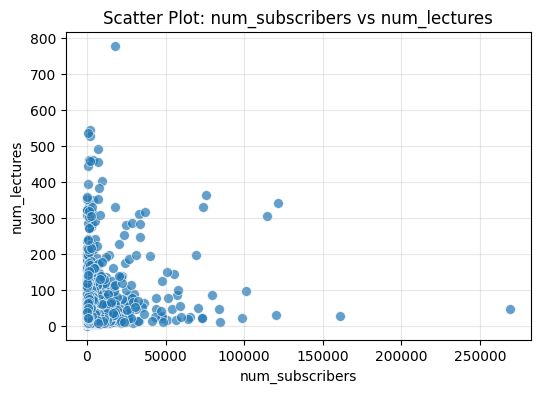

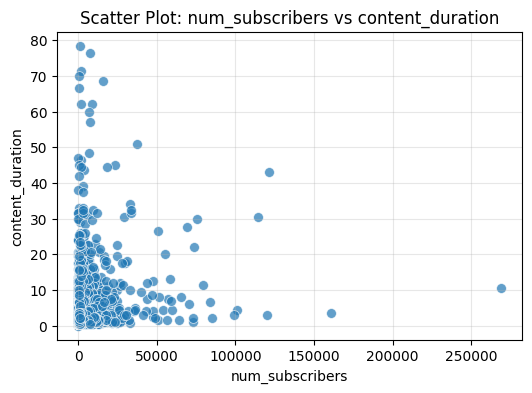

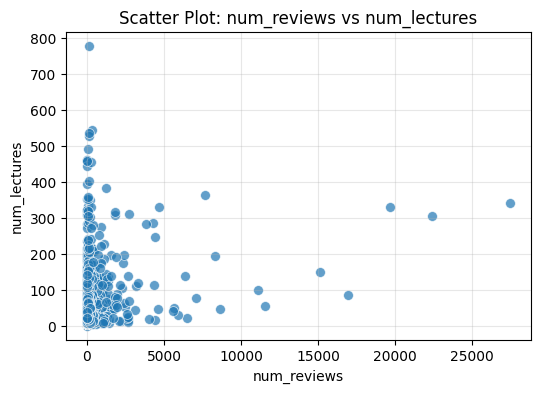

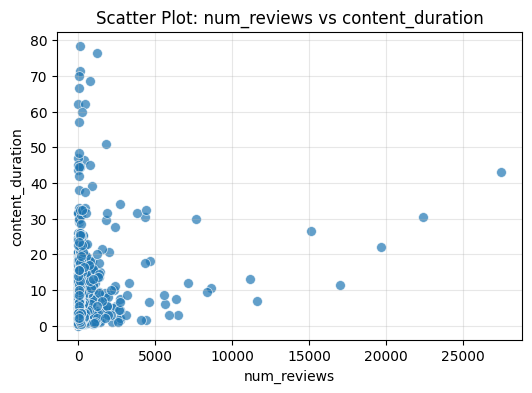

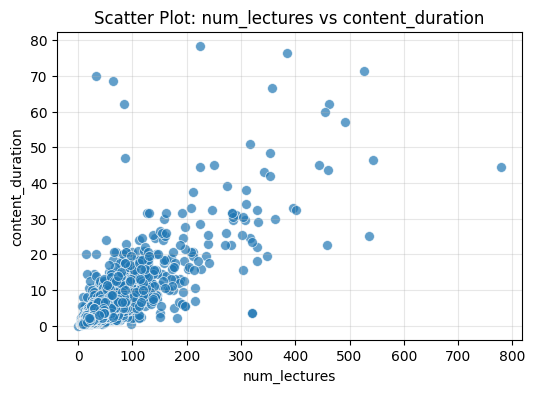

In [120]:
for i, col1 in enumerate(numeric_columns):
    for col2 in numeric_columns[i+1:]:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=numeric_data, x=col1, y=col2, alpha=0.7, s=50)
        plt.title(f"Scatter Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(alpha=0.3)
        plt.show()

BOX 4: Multicollinearity - Correlation Matrix

In [121]:
# Calculate correlation matrix
correlation_matrix = df_no_outliers_udemy.select_dtypes(include=['float64', 'int64']).corr()

# Display correlation matrix
print(correlation_matrix)


                  course_id     price  num_subscribers  num_reviews  \
course_id          1.000000  0.148260        -0.155283    -0.081856   
price              0.148260  1.000000         0.023783     0.078141   
num_subscribers   -0.155283  0.023783         1.000000     0.699118   
num_reviews       -0.081856  0.078141         0.699118     1.000000   
num_lectures      -0.008727  0.313340         0.099088     0.233474   
content_duration  -0.036473  0.300064         0.120606     0.234794   

                  num_lectures  content_duration  
course_id            -0.008727         -0.036473  
price                 0.313340          0.300064  
num_subscribers       0.099088          0.120606  
num_reviews           0.233474          0.234794  
num_lectures          1.000000          0.810548  
content_duration      0.810548          1.000000  


VIF

In [141]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# Define the target variable and features
X = df_no_outliers_udemy[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level') and ensure numeric data
X = pd.get_dummies(X, drop_first=True).astype(float)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print VIF
print("Variance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                    Feature       VIF
0           num_subscribers  2.149568
1               num_reviews  2.183855
2              num_lectures  5.189094
3          content_duration  5.025208
4      level_Beginner Level  1.169684
5        level_Expert Level  1.006299
6  level_Intermediate Level  1.063244


STARTING THE REGRESSION

creating interaction terms since the correlation is high between num_lectures-content_duration and num_reviews-num_subscribers

In [122]:
df_no_outliers_udemy['num_lectures_content_duration'] = df_no_outliers_udemy['num_lectures'] * df_no_outliers_udemy['content_duration']
df_no_outliers_udemy['num_subscribers_num_reviews'] = df_no_outliers_udemy['num_subscribers'] * df_no_outliers_udemy['num_reviews']


C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\3114344232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers_udemy['num_lectures_content_duration'] = df_no_outliers_udemy['num_lectures'] * df_no_outliers_udemy['content_duration']
C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\3114344232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers_udemy['num_subscribers_num_reviews'] = df_no_outliers_udemy['num_subscribers'] * df_no_outliers_udemy['num_reviews']


1. MULTIPLE LINEAR REGRESSION

In [123]:
X = df_no_outliers_udemy[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)






Mean Squared Error: 3354.8036312587424
R-squared: 0.08099357723583911

Linear Regression Coefficients:
                    Feature  Coefficient
0           num_subscribers    -1.280287
1               num_reviews     1.535396
2              num_lectures    12.687619
3          content_duration     7.262236
4      level_Beginner Level    -5.806305
5        level_Expert Level     3.377891
6  level_Intermediate Level    -2.950774


MULTIMPLE LINEAR REGRESSION WITH INTERACTION TERM

In [124]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)






Mean Squared Error: 3345.8839155314663
R-squared: 0.08343702160504696

Linear Regression Coefficients:
                       Feature  Coefficient
0  num_subscribers_num_reviews    -1.873820
1                 num_lectures    12.880387
2             content_duration     7.457322
3         level_Beginner Level    -5.851472
4           level_Expert Level     3.374157
5     level_Intermediate Level    -2.962439


2. POLINOMIAL REGRESSION 

In [125]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = df_no_outliers_udemy['price']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Apply Polynomial Features
poly = PolynomialFeatures(degree=2)  # degree 2 for quadratic features
X_poly = poly.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Fit a Linear Regression model
lr_poly = LinearRegression()
lr_poly.fit(X_train, y_train)

# Evaluate the model
y_pred = lr_poly.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 3360.778448019717
R-squared: 0.07935685104208734


Plotting the residuals => heteroscedasticity

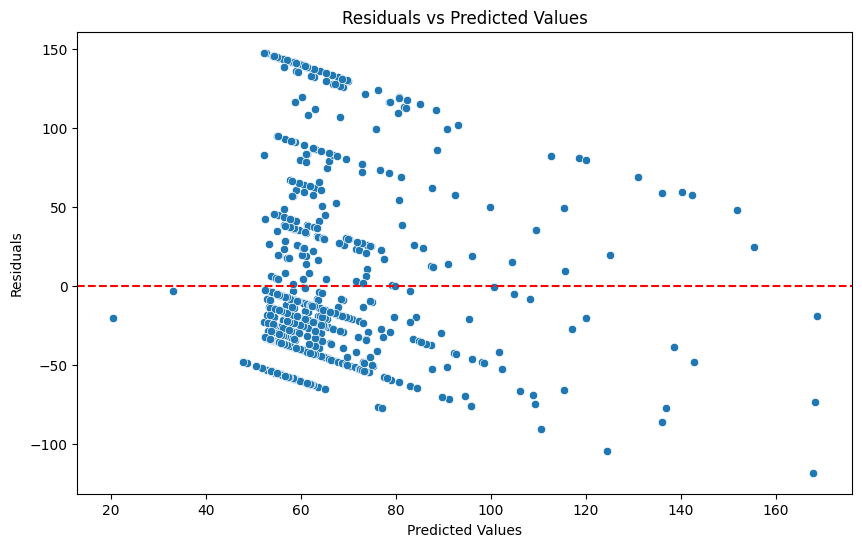

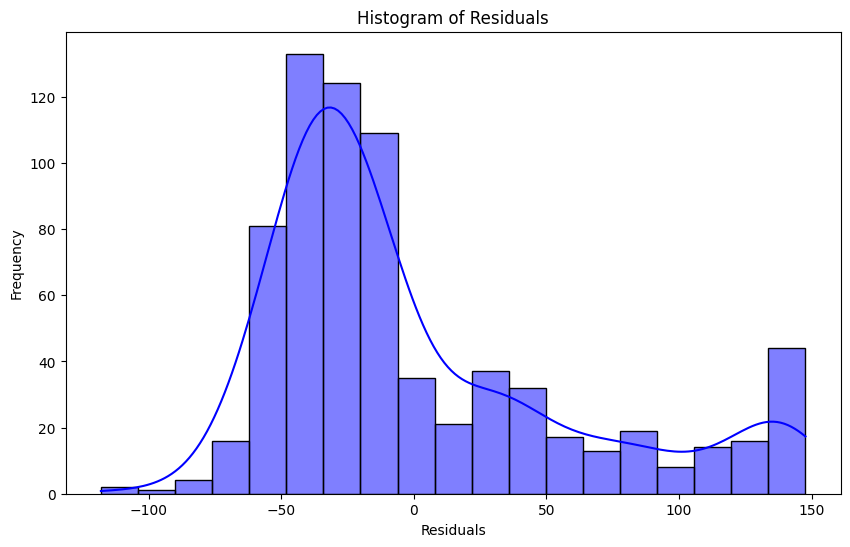

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Optionally: Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


log-transformation on price

C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\1684558998.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers_udemy['price_log'] = np.log(df_no_outliers_udemy['price']+ 1e-9)


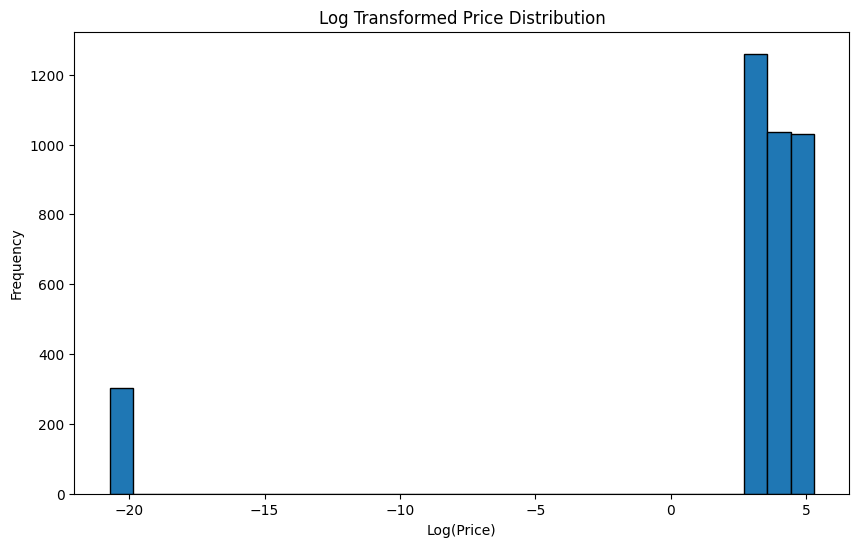

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Log transformation of price
df_no_outliers_udemy['price_log'] = np.log(df_no_outliers_udemy['price']+ 1e-9)

# Plotting the distribution of the log-transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_log'], bins=30, edgecolor='black')
plt.title('Log Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()


Box-Cox transformation

C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\1166568702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers_udemy['price_boxcox'] = df_no_outliers_udemy['price'] + 1e-9
C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\1166568702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers_udemy['price_boxcox'], lambda_boxcox = stats.boxcox(df_no_outliers_udemy['price_boxcox'])


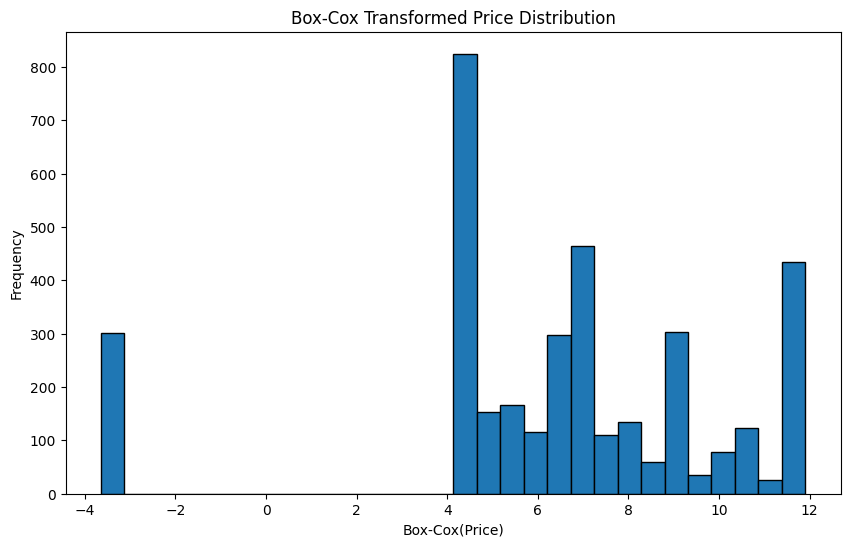

Lambda for Box-Cox transformation: 0.2732505653361542


In [128]:
from scipy import stats

# Adding a small constant to avoid zero or negative values
df_no_outliers_udemy['price_boxcox'] = df_no_outliers_udemy['price'] + 1e-9

# Applying Box-Cox transformation
df_no_outliers_udemy['price_boxcox'], lambda_boxcox = stats.boxcox(df_no_outliers_udemy['price_boxcox'])

# Plotting the distribution of the Box-Cox transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_boxcox'], bins=30, edgecolor='black')
plt.title('Box-Cox Transformed Price Distribution')
plt.xlabel('Box-Cox(Price)')
plt.ylabel('Frequency')
plt.show()

# Check the lambda value for Box-Cox transformation
print(f"Lambda for Box-Cox transformation: {lambda_boxcox}")


Yeo-Johnson transformation on price

C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\233437185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers_udemy['price_yeojohnson'] = pt.fit_transform(df_no_outliers_udemy[['price']])


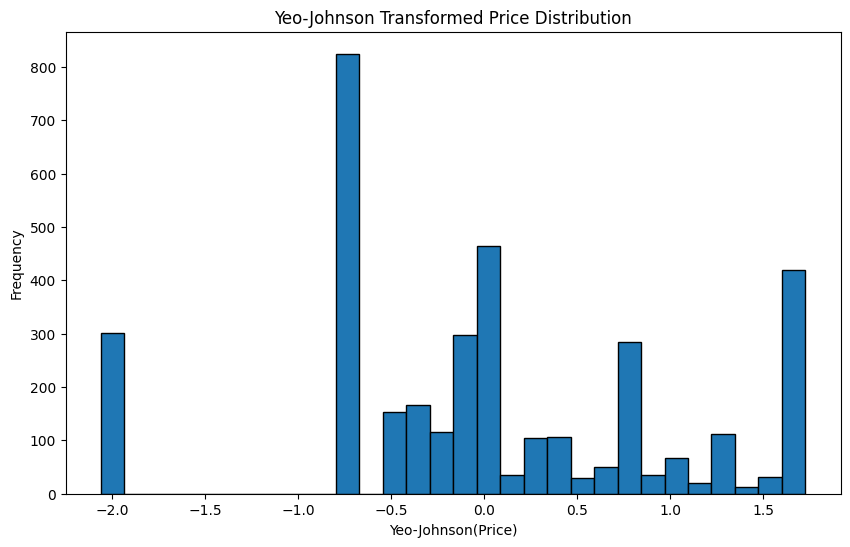

In [129]:
from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df_no_outliers_udemy['price_yeojohnson'] = pt.fit_transform(df_no_outliers_udemy[['price']])

# Plotting the distribution of the Yeo-Johnson transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_yeojohnson'], bins=30, edgecolor='black')
plt.title('Yeo-Johnson Transformed Price Distribution')
plt.xlabel('Yeo-Johnson(Price)')
plt.ylabel('Frequency')
plt.show()


Checking what transformation is the best => Yeo-Johnson

In [130]:
original_skew = df_no_outliers_udemy['price'].skew()
original_kurtosis = df_no_outliers_udemy['price'].kurtosis()

price_log_skew = df_no_outliers_udemy['price_log'].skew()
price_log_kurtosis = df_no_outliers_udemy['price_log'].kurtosis()

price_boxcox_skew = df_no_outliers_udemy['price_boxcox'].skew()
price_boxcox_kurtosis = df_no_outliers_udemy['price_boxcox'].kurtosis()

price_yeojohnson_skew = df_no_outliers_udemy['price_yeojohnson'].skew()
price_yeojohnson_kurtosis = df_no_outliers_udemy['price_yeojohnson'].kurtosis()

print(f"Original Price - Skewness: {original_skew}, Kurtosis: {original_kurtosis}")
print(f"Log Transformed Price - Skewness: {price_log_skew}, Kurtosis: {price_log_kurtosis}")
print(f"Box-Cox Transformed Price - Skewness: {price_boxcox_skew}, Kurtosis: {price_boxcox_kurtosis}")
print(f"Yeo-Johnson Transformed Price - Skewness: {price_yeojohnson_skew}, Kurtosis: {price_yeojohnson_kurtosis}")


Original Price - Skewness: 1.1829250686298813, Kurtosis: 0.18011342822538312
Log Transformed Price - Skewness: -2.9527605636346586, Kurtosis: 6.882878823872897
Box-Cox Transformed Price - Skewness: -1.076346477186815, Kurtosis: 1.5251635551910088
Yeo-Johnson Transformed Price - Skewness: -0.04405491220284836, Kurtosis: -0.23002714646044575


Redo all the regressions with Yeo-Johnson for price

linear regression with yeo johnson on price and num_subscribers_num_reviews as interaction term

In [131]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)

Mean Squared Error: 0.9037964011163541
R-squared: 0.1051944905283223

Linear Regression Coefficients:
                       Feature  Coefficient
0  num_subscribers_num_reviews    -0.072116
1                 num_lectures     0.221748
2             content_duration     0.105793
3         level_Beginner Level    -0.117216
4           level_Expert Level     0.063657
5     level_Intermediate Level    -0.032323


R-squared: 0.15611243896876947
Mean Squared Error: 0.8438875610312306

Polynomial Regression Coefficients:
                                              Feature  Coefficient
0                         num_subscribers_num_reviews    -0.348726
1                                        num_lectures     0.476054
2                                    content_duration     0.158853
3                                level_Beginner Level    -0.064910
4                                  level_Expert Level     0.031390
5                            level_Intermediate Level    -0.016633
6                       num_subscribers_num_reviews^2     0.168693
7            num_subscribers_num_reviews num_lectures     0.134650
8        num_subscribers_num_reviews content_duration     0.006373
9    num_subscribers_num_reviews level_Beginner Level     0.006996
10     num_subscribers_num_reviews level_Expert Level     0.013869
11  num_subscribers_num_reviews level_Intermediate...    -0.018559
12                    

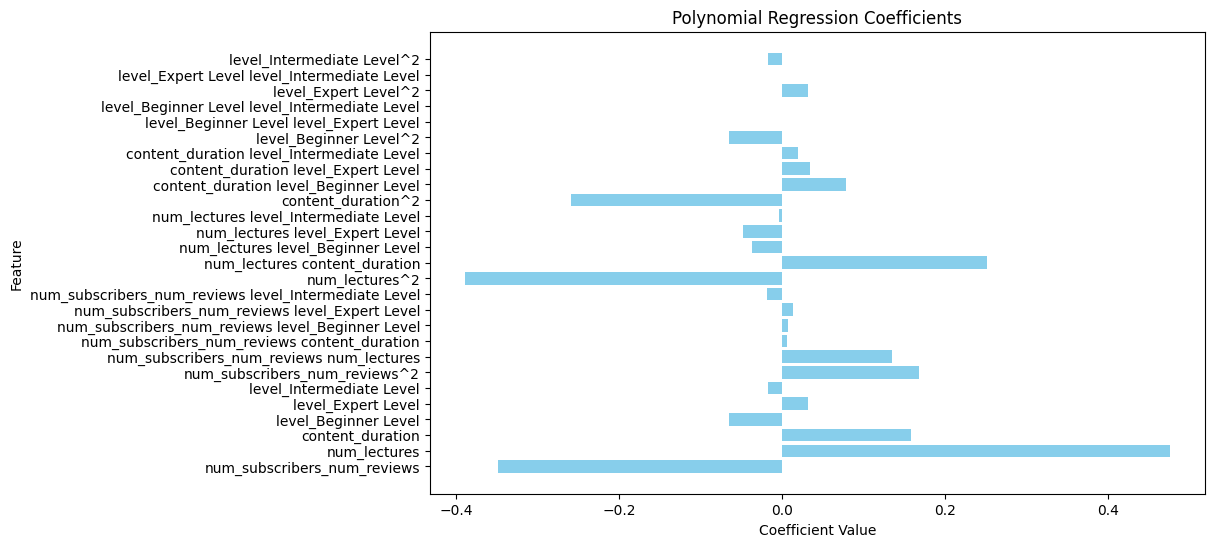

In [144]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level'])

# Define the target variable and features
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a linear regression model with polynomial features
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_poly_scaled, y)

# Evaluate the model
r2 = r2_score(y, lr.predict(X_poly_scaled))
mse = mean_squared_error(y, lr.predict(X_poly_scaled))

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lr.coef_
})

print("\nPolynomial Regression Coefficients:")
print(coefficients)

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Polynomial Regression Coefficients')
plt.show()


R-squared: 0.1769481057744059
Mean Squared Error: 0.8230518942255942

Polynomial Regression Coefficients:
                                            Feature  Coefficient
0                       num_subscribers_num_reviews    -1.219633
1                                      num_lectures     0.916081
2                                  content_duration     0.009632
3                              level_Beginner Level    -0.051251
4                                level_Expert Level     0.013811
..                                              ...          ...
78  level_Beginner Level level_Intermediate Level^2     0.000000
79                             level_Expert Level^3     0.013811
80    level_Expert Level^2 level_Intermediate Level     0.000000
81    level_Expert Level level_Intermediate Level^2     0.000000
82                       level_Intermediate Level^3    -0.016010

[83 rows x 2 columns]

Significant Coefficients:
                                              Feature  Coefficie

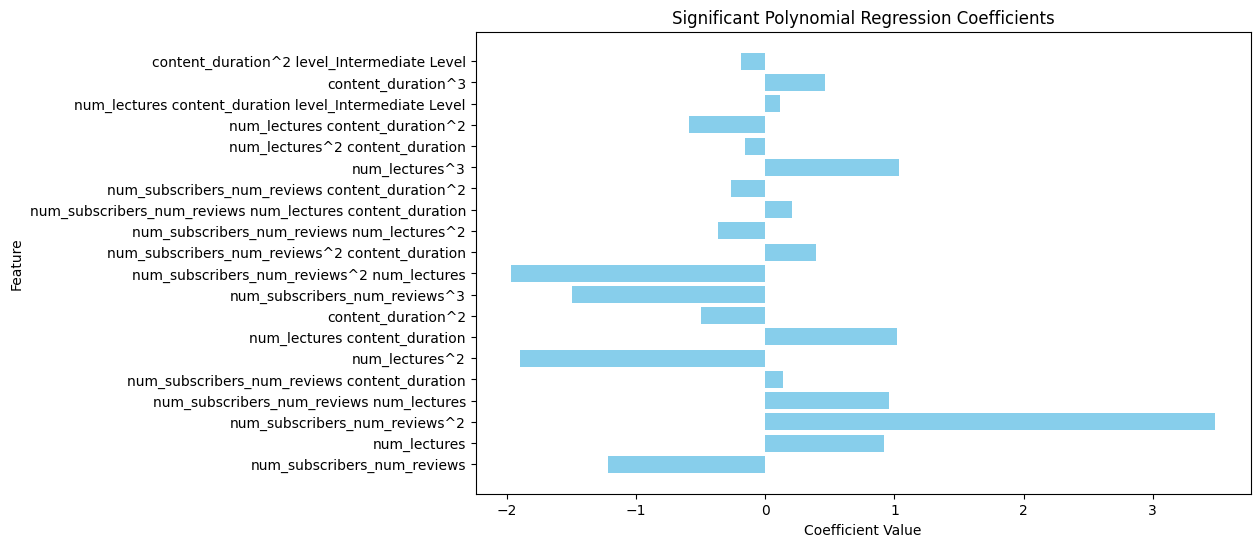

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level'])

# Define the target variable and features
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 3 for higher complexity)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a linear regression model with polynomial features
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_poly_scaled, y)

# Evaluate the model
r2 = r2_score(y, lr.predict(X_poly_scaled))
mse = mean_squared_error(y, lr.predict(X_poly_scaled))

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lr.coef_
})

print("\nPolynomial Regression Coefficients:")
print(coefficients)

significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]
print("\nSignificant Coefficients:")
print(significant_coefficients)

plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients')
plt.show()


simpliflied model, lost some meaning for the variance

R-squared: 0.1769481057744059
Mean Squared Error: 0.8230518942255942

Significant Coefficients:
                                              Feature  Coefficient
0                         num_subscribers_num_reviews    -1.219633
1                                        num_lectures     0.916081
6                       num_subscribers_num_reviews^2     3.485203
7            num_subscribers_num_reviews num_lectures     0.958591
8        num_subscribers_num_reviews content_duration     0.135800
12                                     num_lectures^2    -1.897398
13                      num_lectures content_duration     1.017558
17                                 content_duration^2    -0.493302
27                      num_subscribers_num_reviews^3    -1.496431
28         num_subscribers_num_reviews^2 num_lectures    -1.968798
29     num_subscribers_num_reviews^2 content_duration     0.396032
33         num_subscribers_num_reviews num_lectures^2    -0.362913
34  num_subscribers_num_reviews n

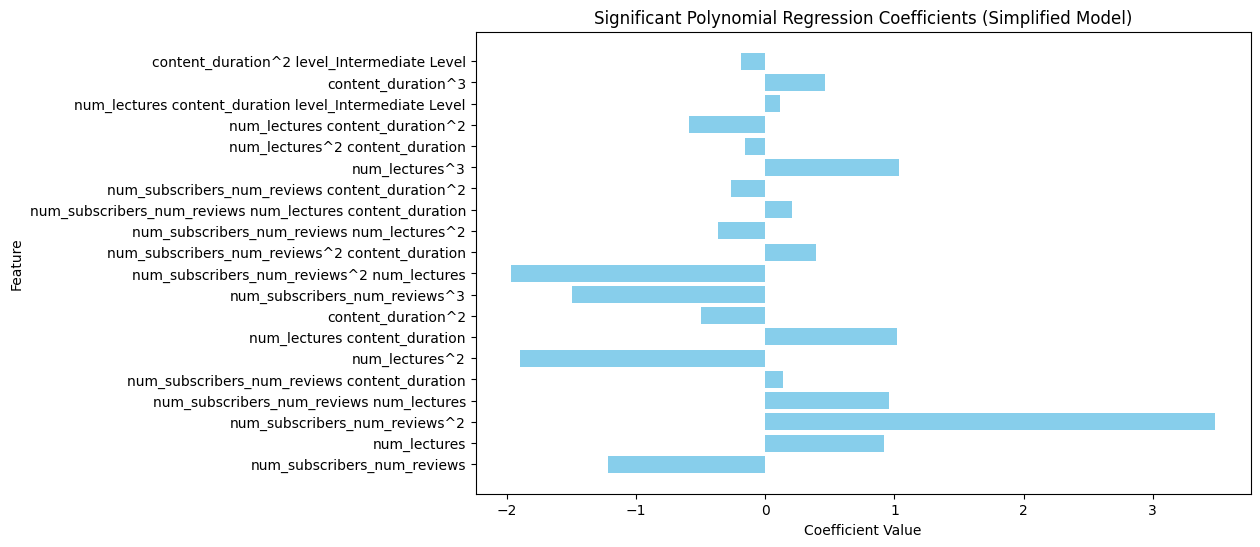

In [146]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level'])

# Define the target variable and features
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 3 for higher complexity)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a linear regression model with polynomial features
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_poly_scaled, y)

# Evaluate the model
r2 = r2_score(y, lr.predict(X_poly_scaled))
mse = mean_squared_error(y, lr.predict(X_poly_scaled))

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lr.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients:")
print(significant_coefficients)

# Simplify by refitting with only significant features
significant_features = significant_coefficients['Feature']
significant_indices = [poly.get_feature_names_out(X.columns).tolist().index(f) for f in significant_features]
X_poly_significant = X_poly_scaled[:, significant_indices]

# Refit the model with significant features
lr_significant = LinearRegression()
lr_significant.fit(X_poly_significant, y)

# Evaluate the simplified model
r2_simplified = r2_score(y, lr_significant.predict(X_poly_significant))
mse_simplified = mean_squared_error(y, lr_significant.predict(X_poly_significant))

print(f"Simplified R-squared: {r2_simplified}")
print(f"Simplified Mean Squared Error: {mse_simplified}")

# Visualize significant coefficients for the simplified model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Simplified Model)')
plt.show()


lasso regression

c:\users\teodo\appdata\local\activestate\cache\f496fb7e\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5294883336787279, tolerance: 0.28025523126950935
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\teodo\appdata\local\activestate\cache\f496fb7e\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.916668570856473, tolerance: 0.28025523126950935
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\teodo\appdata\local\activestate\cache\f496fb7e\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.888812000468079, tolerance: 0.28025523126950935
  model = cd_fast.enet_coordinate_descent

Lasso R-squared: 0.14339813178230076
Lasso Mean Squared Error: 0.8566018682176993

Significant Coefficients (Lasso):
                                              Feature  Coefficient
0                         num_subscribers_num_reviews    -0.057331
1                                        num_lectures     0.346720
2                                    content_duration     0.114750
3                                level_Beginner Level    -0.077762
4                                  level_Expert Level     0.044569
5                            level_Intermediate Level    -0.004918
9    num_subscribers_num_reviews level_Beginner Level    -0.031540
10     num_subscribers_num_reviews level_Expert Level     0.003634
11  num_subscribers_num_reviews level_Intermediate...    -0.006123
12                                     num_lectures^2    -0.150078
18              content_duration level_Beginner Level     0.016297
21                             level_Beginner Level^2    -0.017960
24          

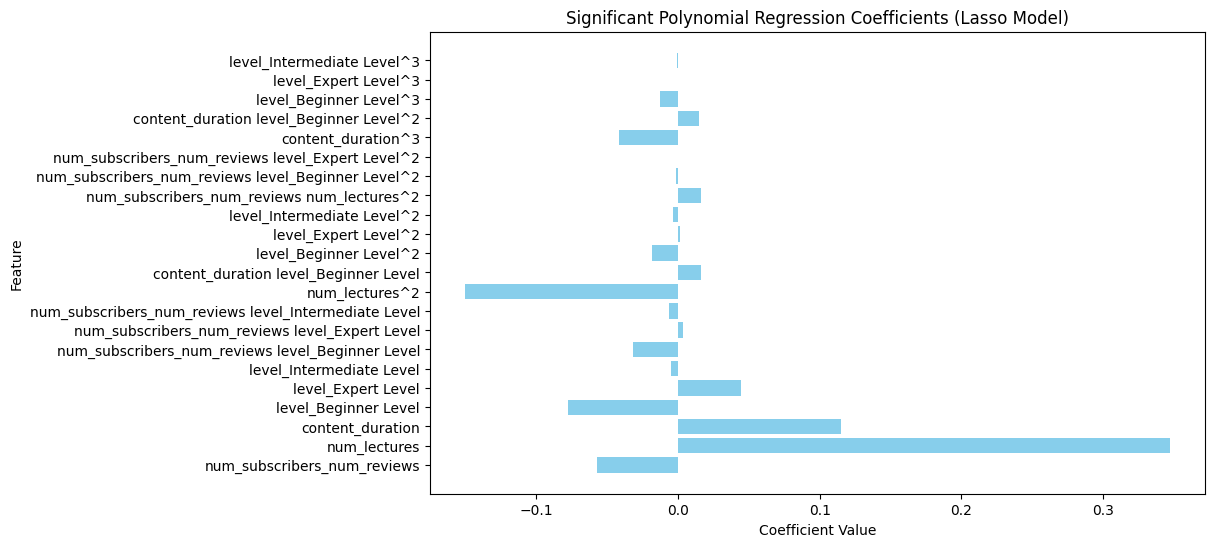

In [148]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level'])

# Define the target variable and features
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 3 for higher complexity)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Lasso regression model with polynomial features
lasso = LassoCV(cv=5, random_state=42).fit(X_poly_scaled, y)

# Evaluate the model
r2_lasso = lasso.score(X_poly_scaled, y)
mse_lasso = mean_squared_error(y, lasso.predict(X_poly_scaled))

print(f"Lasso R-squared: {r2_lasso}")
print(f"Lasso Mean Squared Error: {mse_lasso}")

# Display significant model coefficients (non-zero coefficients)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lasso.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0]

print("\nSignificant Coefficients (Lasso):")
print(significant_coefficients)

# Visualize significant coefficients for the Lasso model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Lasso Model)')
plt.show()


Simplified Lasso R-squared: 0.14345163054176524
Simplified Lasso Mean Squared Error: 0.8565483694582349

Significant Coefficients (Simplified Lasso):
                                              Feature  Coefficient
0                         num_subscribers_num_reviews    -0.059874
1                                        num_lectures     0.375086
2                                    content_duration     0.099479
3                                level_Beginner Level    -0.078607
4                                  level_Expert Level     0.045122
5                            level_Intermediate Level    -0.005636
7            num_subscribers_num_reviews num_lectures     0.009638
9    num_subscribers_num_reviews level_Beginner Level    -0.033888
10     num_subscribers_num_reviews level_Expert Level     0.004558
11  num_subscribers_num_reviews level_Intermediate...    -0.006643
12                                     num_lectures^2    -0.175401
17                                 content_dur

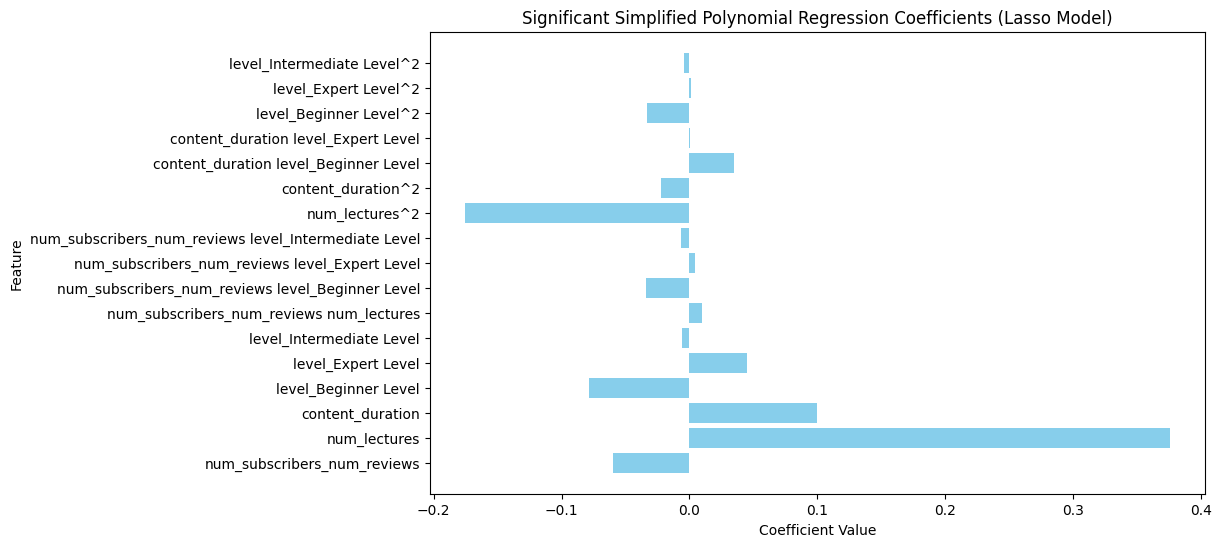

In [150]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level'])

# Define the target variable and features
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 2 for simplification)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Lasso regression model with simplified polynomial features
lasso = LassoCV(cv=5, random_state=42).fit(X_poly_scaled, y)

# Evaluate the model
r2_lasso = lasso.score(X_poly_scaled, y)
mse_lasso = mean_squared_error(y, lasso.predict(X_poly_scaled))

print(f"Simplified Lasso R-squared: {r2_lasso}")
print(f"Simplified Lasso Mean Squared Error: {mse_lasso}")

# Display significant model coefficients (non-zero coefficients)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lasso.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0]

print("\nSignificant Coefficients (Simplified Lasso):")
print(significant_coefficients)

# Visualize significant coefficients for the simplified Lasso model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Simplified Polynomial Regression Coefficients (Lasso Model)')
plt.show()


ocus on the most impactful predictors, num_lectures and content_duration, while retaining their polynomial relationships.

Focused Lasso R-squared: 0.12494856355572781
Focused Lasso Mean Squared Error: 0.8750514364442723

Significant Coefficients (Focused Lasso):
                         Feature  Coefficient
0                   num_lectures     0.441733
1               content_duration     0.207846
2                 num_lectures^2    -0.305377
3  num_lectures content_duration     0.136838
4             content_duration^2    -0.196818


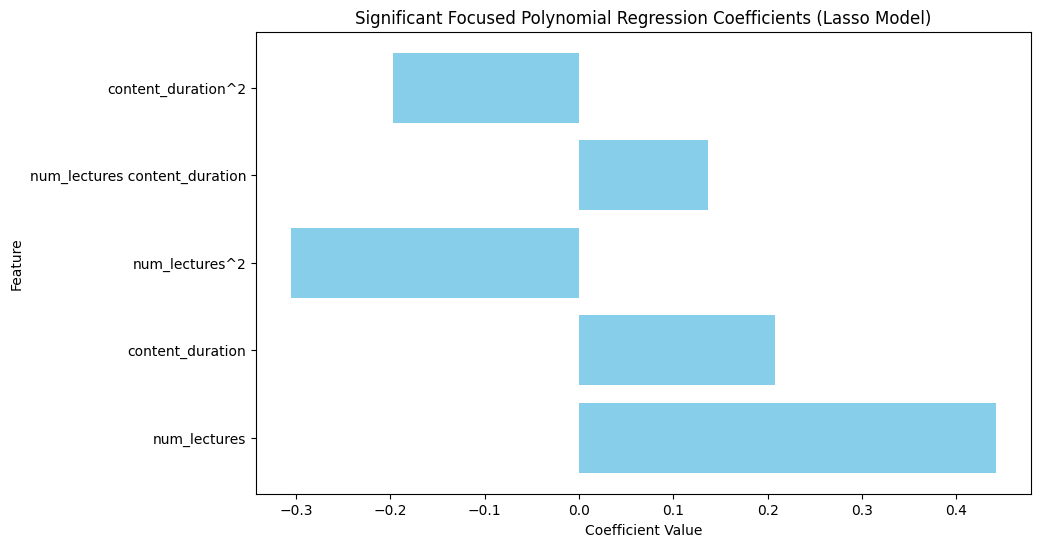

In [151]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level'])

# Define the target variable and features
X = df_no_outliers_udemy[['num_lectures', 'content_duration']]  # Focused Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Apply Polynomial Features (degree 2 for focused analysis)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Lasso regression model with focused polynomial features
lasso = LassoCV(cv=5, random_state=42).fit(X_poly_scaled, y)

# Evaluate the model
r2_lasso = lasso.score(X_poly_scaled, y)
mse_lasso = mean_squared_error(y, lasso.predict(X_poly_scaled))

print(f"Focused Lasso R-squared: {r2_lasso}")
print(f"Focused Lasso Mean Squared Error: {mse_lasso}")

# Display significant model coefficients (non-zero coefficients)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lasso.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0]

print("\nSignificant Coefficients (Focused Lasso):")
print(significant_coefficients)

# Visualize significant coefficients for the focused Lasso model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Focused Polynomial Regression Coefficients (Lasso Model)')
plt.show()


Ridge R-squared (No Polynomials): 0.12333245596978304
Ridge Mean Squared Error (No Polynomials): 0.8766675440302171

Ridge Coefficients (No Polynomials):
                       Feature  Coefficient
0  num_subscribers_num_reviews    -0.077273
1                 num_lectures     0.212489
2             content_duration     0.114421
3         level_Beginner Level    -0.107242
4           level_Expert Level     0.059385
5     level_Intermediate Level    -0.027964


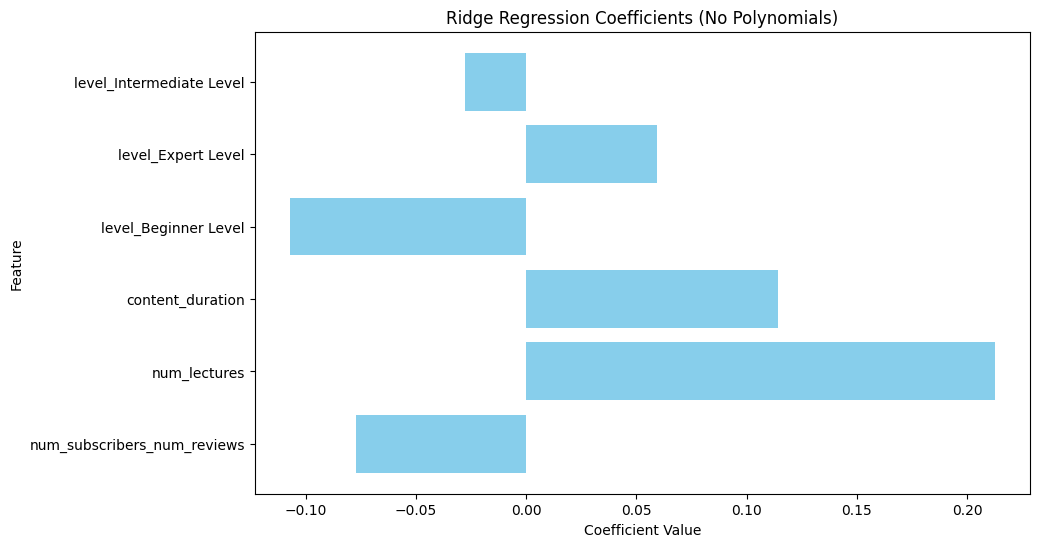

In [155]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a Ridge regression model without polynomial features
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_scaled))

print(f"Ridge R-squared (No Polynomials): {r2_ridge}")
print(f"Ridge Mean Squared Error (No Polynomials): {mse_ridge}")

# Display significant model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
})
print("\nRidge Coefficients (No Polynomials):")
print(coefficients)

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Ridge Regression Coefficients (No Polynomials)')
plt.show()


Ridge R-squared: 0.15611048447710618
Ridge Mean Squared Error: 0.8438895155228939

Significant Coefficients (Ridge Regression):
                                     Feature  Coefficient
0                num_subscribers_num_reviews    -0.346570
1                               num_lectures     0.473638
2                           content_duration     0.159779
6              num_subscribers_num_reviews^2     0.166431
7   num_subscribers_num_reviews num_lectures     0.133338
12                            num_lectures^2    -0.384017
13             num_lectures content_duration     0.244581
17                        content_duration^2    -0.255318


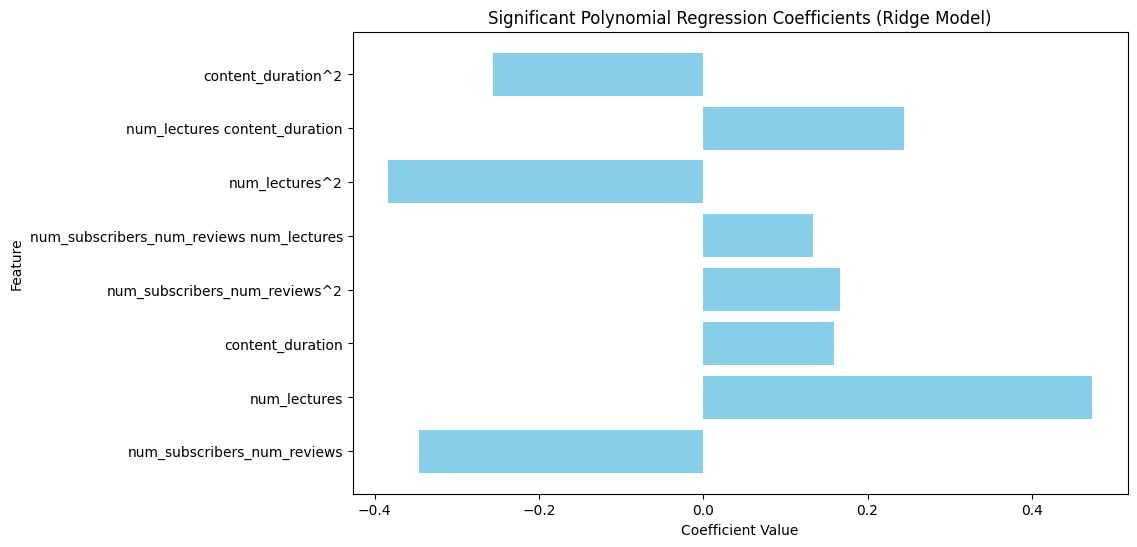

In [158]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level'])

# Define the target variable and features
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 2 for moderate complexity)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Ridge regression model with polynomial features
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_poly_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_poly_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

print(f"Ridge R-squared: {r2_ridge}")
print(f"Ridge Mean Squared Error: {mse_ridge}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': ridge.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients (Ridge Regression):")
print(significant_coefficients)

# Visualize significant coefficients for the Ridge model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Ridge Model)')
plt.show()


Ridge for every subject


Processing subject: Business Finance
Ridge R-squared for Business Finance: 0.13809548337699085
Ridge Mean Squared Error for Business Finance: 0.9159884165906259

Significant Coefficients for Business Finance (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.319985
1                                   num_lectures     0.505277
2                               content_duration     0.110358
6                  num_subscribers_num_reviews^2     0.328158
7       num_subscribers_num_reviews num_lectures    -0.710737
8   num_subscribers_num_reviews content_duration     0.729601
12                                num_lectures^2    -0.337157
13                 num_lectures content_duration     0.246034
17                            content_duration^2    -0.355050


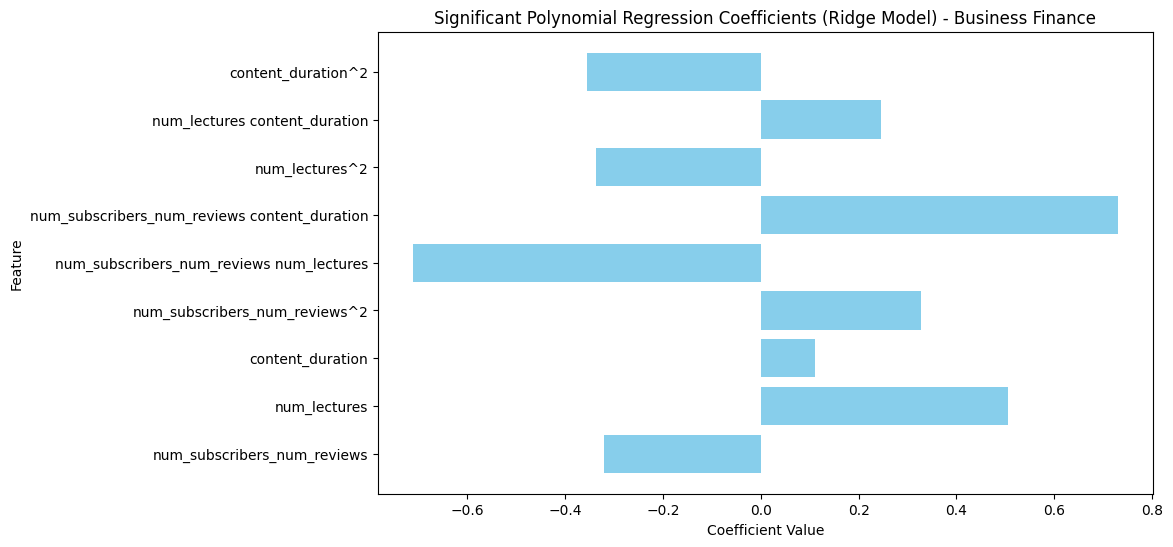


Processing subject: Graphic Design
Ridge R-squared for Graphic Design: 0.18905784447640395
Ridge Mean Squared Error for Graphic Design: 0.6839526624399547

Significant Coefficients for Graphic Design (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.620029
1                                   num_lectures     0.786287
2                               content_duration    -0.114853
6                  num_subscribers_num_reviews^2     0.392353
7       num_subscribers_num_reviews num_lectures     1.113947
8   num_subscribers_num_reviews content_duration    -0.810308
12                                num_lectures^2    -0.445294
13                 num_lectures content_duration    -0.267740
15               num_lectures level_Expert Level    -0.211421
17                            content_duration^2     0.338378


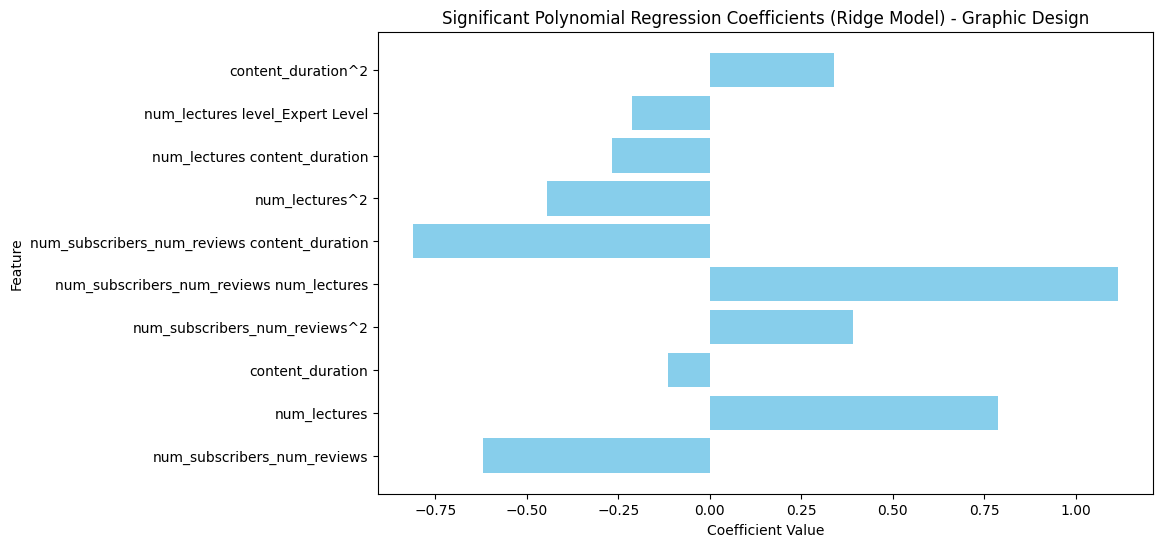


Processing subject: Musical Instruments
Ridge R-squared for Musical Instruments: 0.21198018379888983
Ridge Mean Squared Error for Musical Instruments: 0.4554991738768646

Significant Coefficients for Musical Instruments (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.252119
1                                   num_lectures     0.384524
6                  num_subscribers_num_reviews^2     0.106438
8   num_subscribers_num_reviews content_duration     0.243833
12                                num_lectures^2    -0.275065
14             num_lectures level_Beginner Level    -0.101849
18         content_duration level_Beginner Level     0.192217


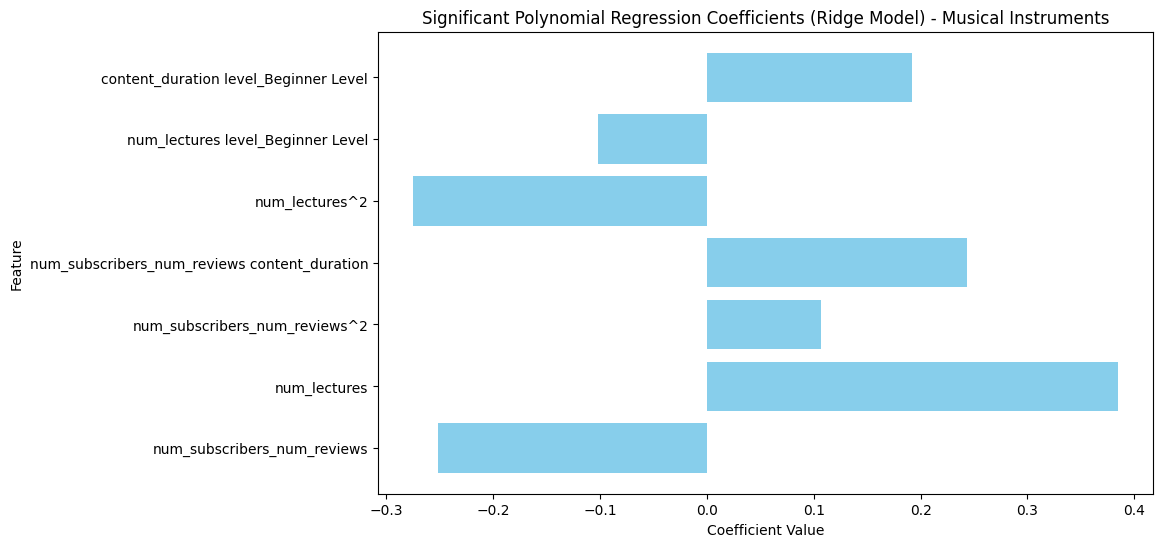


Processing subject: Web Development
Ridge R-squared for Web Development: 0.2075694051921836
Ridge Mean Squared Error for Web Development: 0.9705203138885754

Significant Coefficients for Web Development (Ridge Regression):
                                     Feature  Coefficient
0                num_subscribers_num_reviews    -0.590934
1                               num_lectures     0.536560
2                           content_duration     0.238427
6              num_subscribers_num_reviews^2     0.265476
7   num_subscribers_num_reviews num_lectures     0.203006
12                            num_lectures^2    -0.211892
13             num_lectures content_duration    -0.221020
15           num_lectures level_Expert Level    -0.182838
16     num_lectures level_Intermediate Level     0.152966
19       content_duration level_Expert Level     0.150299


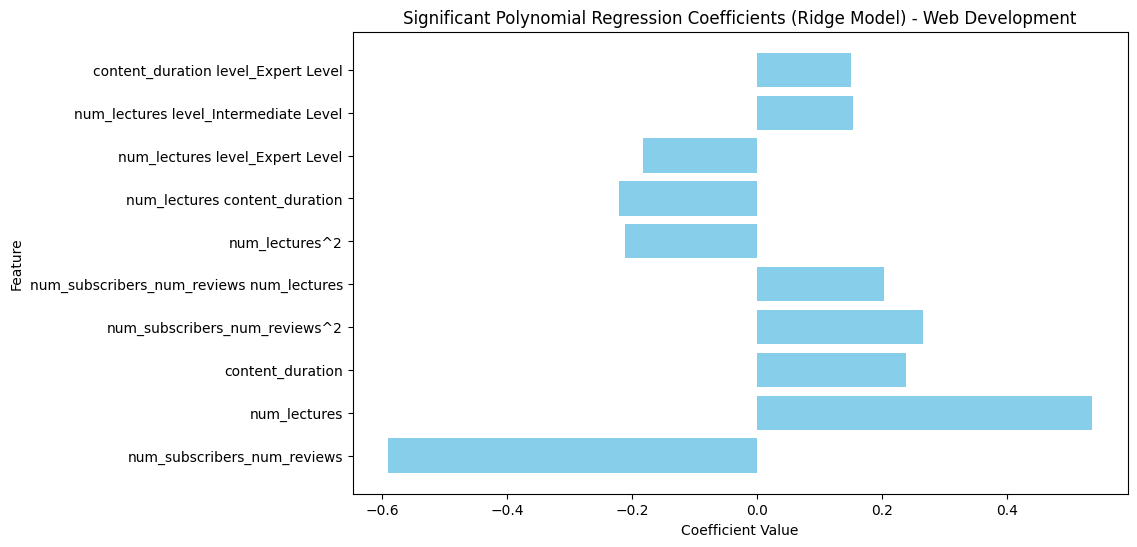


Summary for Business Finance:
R-squared: 0.13809548337699085
MSE: 0.9159884165906259

Summary for Graphic Design:
R-squared: 0.18905784447640395
MSE: 0.6839526624399547

Summary for Musical Instruments:
R-squared: 0.21198018379888983
MSE: 0.4554991738768646

Summary for Web Development:
R-squared: 0.2075694051921836
MSE: 0.9705203138885754


In [159]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Split the data by subject
subjects = df_no_outliers_udemy['subject'].unique()
subject_results = {}

for subject in subjects:
    print(f"\nProcessing subject: {subject}")
    
    # Filter the data for the current subject
    df_subject = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == subject]
    
    # Define the target variable and features
    X = df_subject[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
    y = df_subject['price_yeojohnson']

    # Encode categorical variables (e.g., 'level')
    X = pd.get_dummies(X, drop_first=True).astype(float)

    # Apply Polynomial Features (degree 2 for moderate complexity)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Standardize the features
    scaler = StandardScaler()
    X_poly_scaled = scaler.fit_transform(X_poly)

    # Fit a Ridge regression model with polynomial features
    ridge = Ridge(alpha=1.0)  # Regularization strength
    ridge.fit(X_poly_scaled, y)

    # Evaluate the model
    r2_ridge = ridge.score(X_poly_scaled, y)
    mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

    print(f"Ridge R-squared for {subject}: {r2_ridge}")
    print(f"Ridge Mean Squared Error for {subject}: {mse_ridge}")

    # Display significant model coefficients (absolute value > 0.1)
    coefficients = pd.DataFrame({
        'Feature': poly.get_feature_names_out(X.columns),
        'Coefficient': ridge.coef_
    })
    significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

    print(f"\nSignificant Coefficients for {subject} (Ridge Regression):")
    print(significant_coefficients)

    # Store the results
    subject_results[subject] = {
        'R-squared': r2_ridge,
        'MSE': mse_ridge,
        'Significant Coefficients': significant_coefficients
    }

    # Visualize significant coefficients for the Ridge model
    plt.figure(figsize=(10, 6))
    plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Significant Polynomial Regression Coefficients (Ridge Model) - {subject}')
    plt.show()

# Print summary of results
for subject, results in subject_results.items():
    print(f"\nSummary for {subject}:")
    print(f"R-squared: {results['R-squared']}")
    print(f"MSE: {results['MSE']}")


Ridge for web dev vs all others


Processing subject: Web Development
Ridge R-squared for Web Development: 0.2075694051921836
Ridge Mean Squared Error for Web Development: 0.9705203138885754

Significant Coefficients for Web Development (Ridge Regression):
                                     Feature  Coefficient
0                num_subscribers_num_reviews    -0.590934
1                               num_lectures     0.536560
2                           content_duration     0.238427
6              num_subscribers_num_reviews^2     0.265476
7   num_subscribers_num_reviews num_lectures     0.203006
12                            num_lectures^2    -0.211892
13             num_lectures content_duration    -0.221020
15           num_lectures level_Expert Level    -0.182838
16     num_lectures level_Intermediate Level     0.152966
19       content_duration level_Expert Level     0.150299


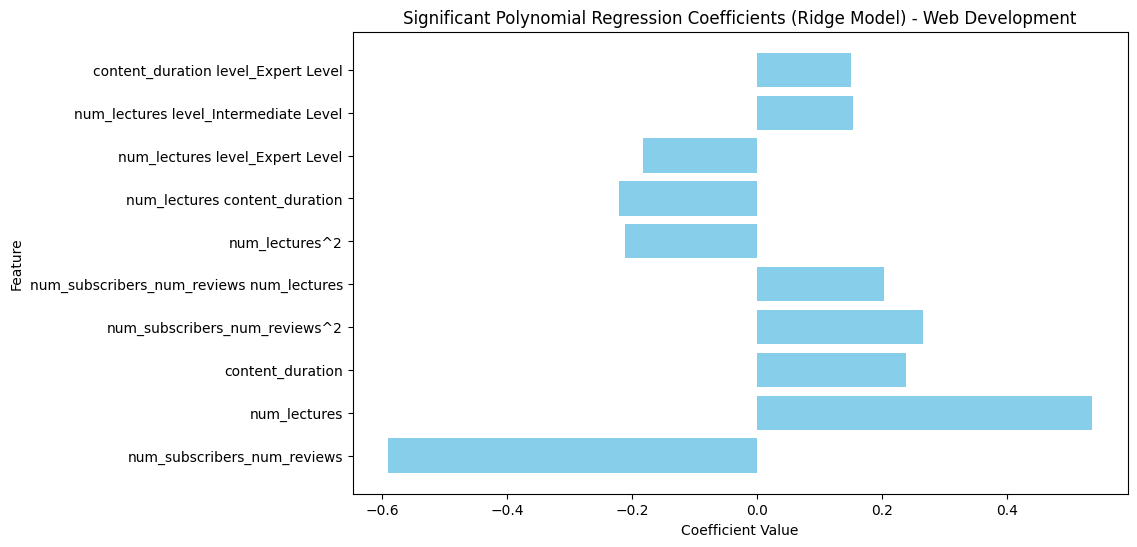


Processing subject: Other Subjects
Ridge R-squared for Other Subjects: 0.1324179493867046
Ridge Mean Squared Error for Other Subjects: 0.7661762329689366

Significant Coefficients for Other Subjects (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.189155
1                                   num_lectures     0.430902
2                               content_duration     0.102807
8   num_subscribers_num_reviews content_duration     0.190689
12                                num_lectures^2    -0.364646
13                 num_lectures content_duration     0.275894
17                            content_duration^2    -0.254464


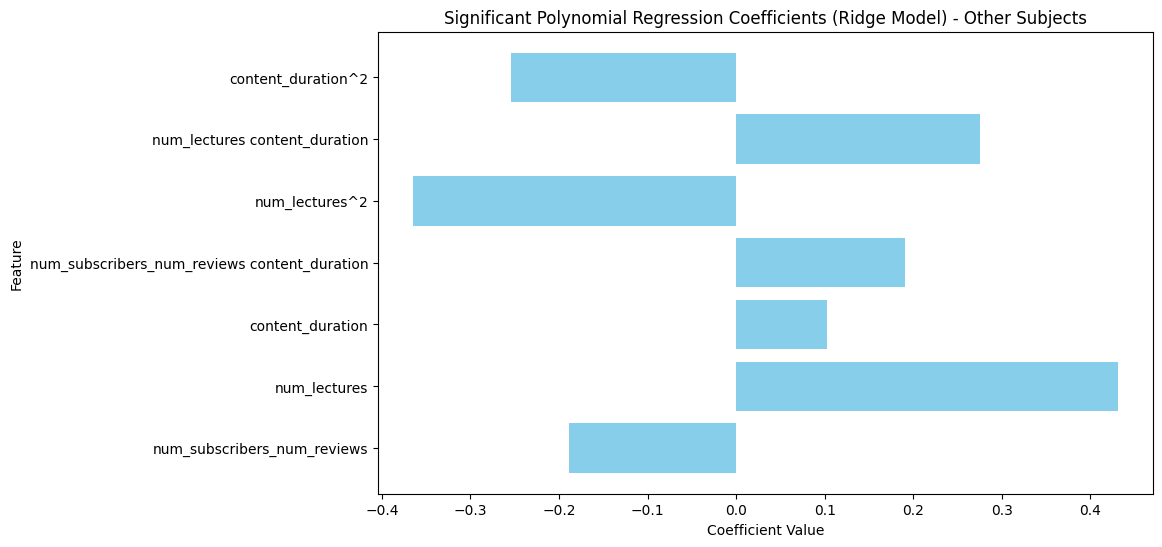


Summary for Web Development:
R-squared: 0.2075694051921836
MSE: 0.9705203138885754

Summary for Other Subjects:
R-squared: 0.1324179493867046
MSE: 0.7661762329689366


In [160]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Split the data into Web Development and Other subjects
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']
other_subjects_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] != 'Web Development']

subject_results = {}

# Function to process a specific dataset
def process_subject(df, label):
    print(f"\nProcessing subject: {label}")
    
    # Define the target variable and features
    X = df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
    y = df['price_yeojohnson']

    # Encode categorical variables (e.g., 'level')
    X = pd.get_dummies(X, drop_first=True).astype(float)

    # Apply Polynomial Features (degree 2 for moderate complexity)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Standardize the features
    scaler = StandardScaler()
    X_poly_scaled = scaler.fit_transform(X_poly)

    # Fit a Ridge regression model with polynomial features
    ridge = Ridge(alpha=1.0)  # Regularization strength
    ridge.fit(X_poly_scaled, y)

    # Evaluate the model
    r2_ridge = ridge.score(X_poly_scaled, y)
    mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

    print(f"Ridge R-squared for {label}: {r2_ridge}")
    print(f"Ridge Mean Squared Error for {label}: {mse_ridge}")

    # Display significant model coefficients (absolute value > 0.1)
    coefficients = pd.DataFrame({
        'Feature': poly.get_feature_names_out(X.columns),
        'Coefficient': ridge.coef_
    })
    significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

    print(f"\nSignificant Coefficients for {label} (Ridge Regression):")
    print(significant_coefficients)

    # Visualize significant coefficients for the Ridge model
    plt.figure(figsize=(10, 6))
    plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Significant Polynomial Regression Coefficients (Ridge Model) - {label}')
    plt.show()

    # Store the results
    subject_results[label] = {
        'R-squared': r2_ridge,
        'MSE': mse_ridge,
        'Significant Coefficients': significant_coefficients
    }

# Process Web Development
process_subject(web_dev_df, 'Web Development')

# Process Other Subjects
process_subject(other_subjects_df, 'Other Subjects')

# Print summary of results
for subject, results in subject_results.items():
    print(f"\nSummary for {subject}:")
    print(f"R-squared: {results['R-squared']}")
    print(f"MSE: {results['MSE']}")


Ridge of degree 4 only for web dev - R square 0.26

Ridge R-squared for Web Development: 0.2609849474128456
Ridge Mean Squared Error for Web Development: 0.9051002390678928

Significant Coefficients for Web Development (Ridge Regression):
                                           Feature  Coefficient
0                      num_subscribers_num_reviews    -0.810681
1                                     num_lectures     0.650949
2                                 content_duration     0.381329
6                    num_subscribers_num_reviews^2     1.269274
8     num_subscribers_num_reviews content_duration     0.166658
..                                             ...          ...
176          content_duration^3 level_Expert Level    -0.103843
177    content_duration^3 level_Intermediate Level     0.357690
178      content_duration^2 level_Beginner Level^2     0.190625
183  content_duration^2 level_Intermediate Level^2    -0.404881
193    content_duration level_Intermediate Level^3     0.167676

[72 rows x 2 columns]


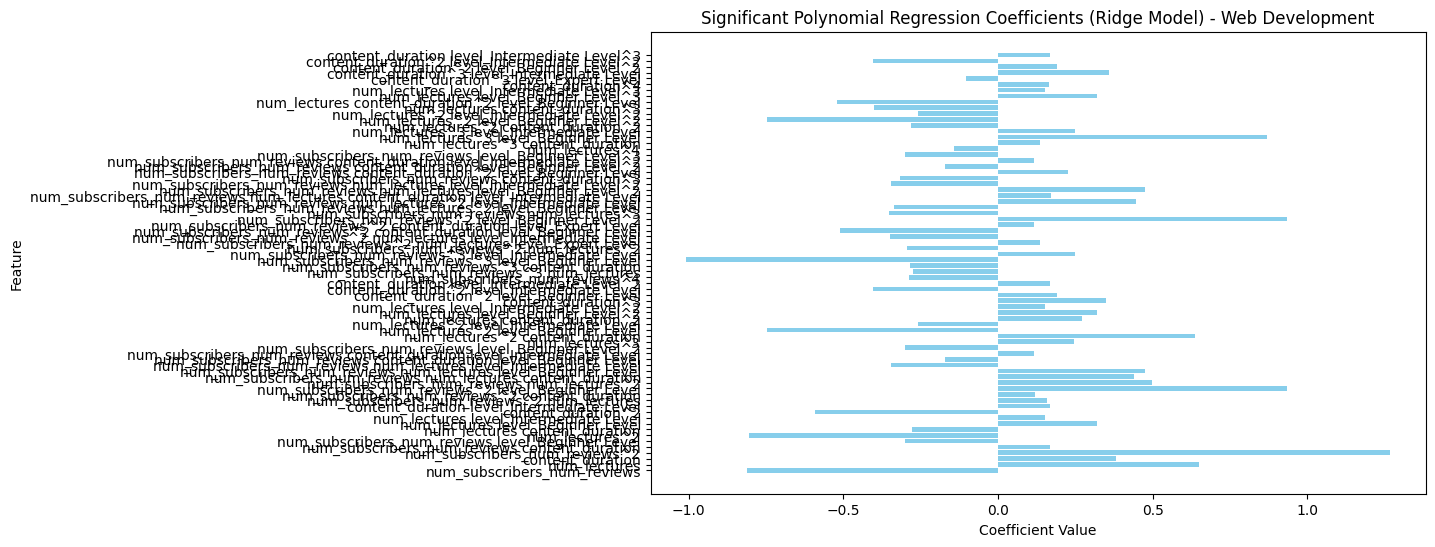

In [167]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Filter the data for Web Development only
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# Define the target variable and features
X = web_dev_df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = web_dev_df['price_yeojohnson']

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 2 for moderate complexity)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Ridge regression model with polynomial features
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_poly_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_poly_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

print(f"Ridge R-squared for Web Development: {r2_ridge}")
print(f"Ridge Mean Squared Error for Web Development: {mse_ridge}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': ridge.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients for Web Development (Ridge Regression):")
print(significant_coefficients)

# Visualize significant coefficients for the Ridge model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Ridge Model) - Web Development')
plt.show()


RIDGE LOG KEEP IT

Ridge R-squared for Web Development with Log Transform: 0.20613126343361865
Ridge Mean Squared Error for Web Development with Log Transform: 0.972281661570106

Significant Coefficients for Web Development (Ridge Regression with Log Transform):
                Feature  Coefficient
0   log_num_subscribers    -0.236426
1          num_lectures     0.186665
2  log_content_duration     0.330986


C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\213568040.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_num_subscribers'] = np.log1p(X['num_subscribers_num_reviews'])
C:\Users\teodo\AppData\Local\Temp\ipykernel_3336\213568040.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_content_duration'] = np.log1p(X['content_duration'])


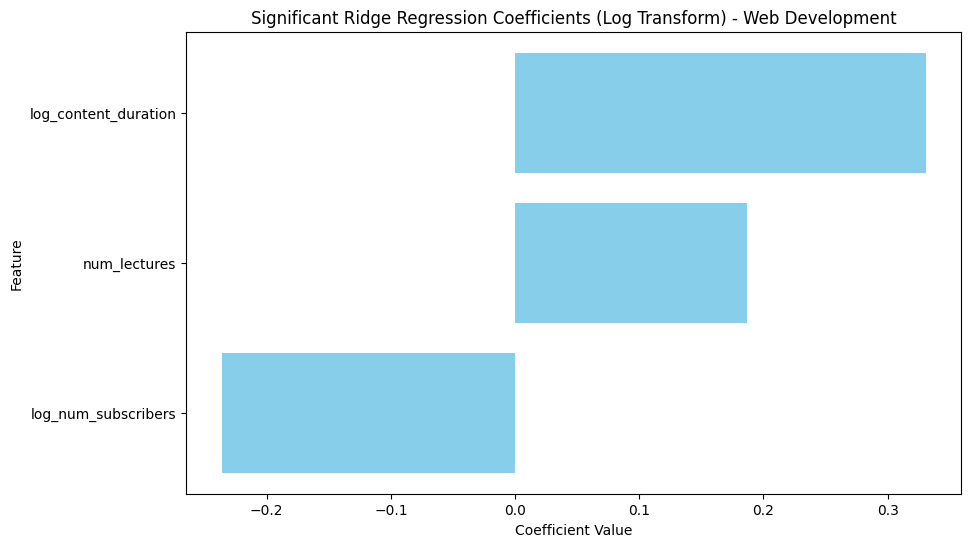

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Filter the data for Web Development only
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# Define the target variable and features
X = web_dev_df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = web_dev_df['price_yeojohnson']

# Log-transform the continuous variables
X['log_num_subscribers'] = np.log1p(X['num_subscribers_num_reviews'])
X['log_content_duration'] = np.log1p(X['content_duration'])

# Drop original variables and keep transformed ones
X = X[['log_num_subscribers', 'num_lectures', 'log_content_duration', 'level']]

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a Ridge regression model
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_scaled))

print(f"Ridge R-squared for Web Development with Log Transform: {r2_ridge}")
print(f"Ridge Mean Squared Error for Web Development with Log Transform: {mse_ridge}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients for Web Development (Ridge Regression with Log Transform):")
print(significant_coefficients)

# Visualize significant coefficients for the Ridge model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Ridge Regression Coefficients (Log Transform) - Web Development')
plt.show()


cross validation for degree 4 and log


Cross-validation for Log Transform Model
Cross-validated R-squared (Log Transform): 0.1245

Cross-validation for Polynomial Features Model
Cross-validated R-squared (Polynomial Features, Degree 4): -6.1036

Significant Coefficients for Web Development (Polynomial Features, Degree 4):
                                           Feature  Coefficient
0                      num_subscribers_num_reviews    -0.810681
1                                     num_lectures     0.650949
2                                 content_duration     0.381329
6                    num_subscribers_num_reviews^2     1.269274
8     num_subscribers_num_reviews content_duration     0.166658
..                                             ...          ...
176          content_duration^3 level_Expert Level    -0.103843
177    content_duration^3 level_Intermediate Level     0.357690
178      content_duration^2 level_Beginner Level^2     0.190625
183  content_duration^2 level_Intermediate Level^2    -0.404881
193    con

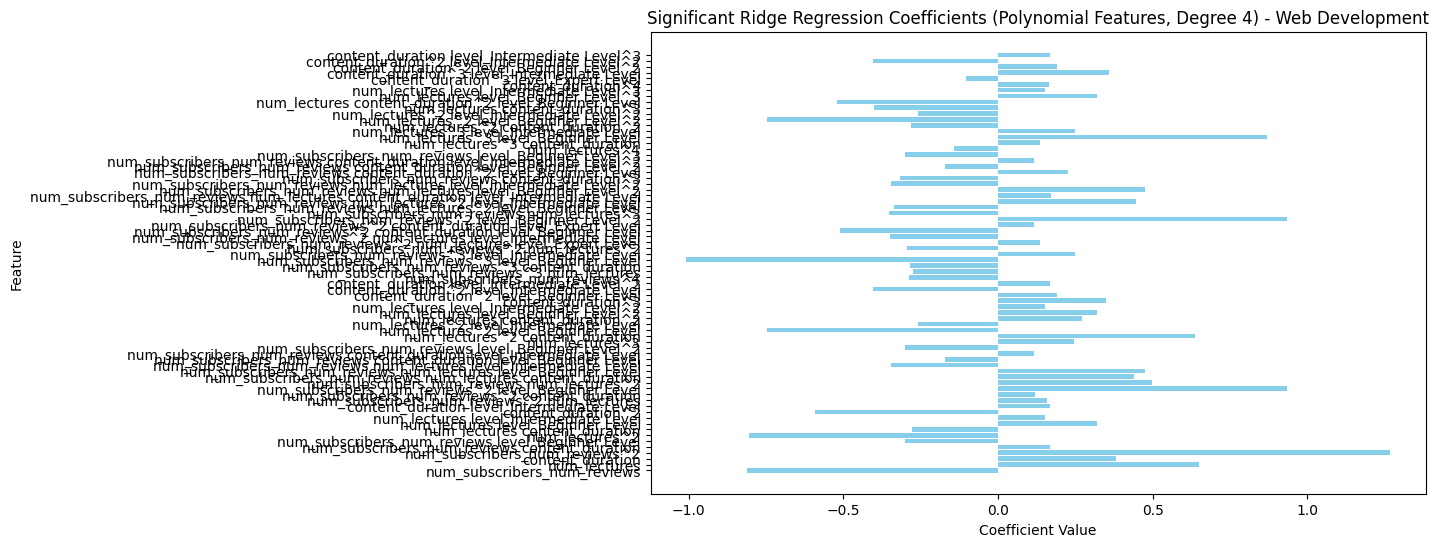

In [172]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Filter the data for Web Development only
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# Define the target variable and features
X = web_dev_df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = web_dev_df['price_yeojohnson']

# Cross-validation for Log Transform Model
print("\nCross-validation for Log Transform Model")
# Log-transform the continuous variables
X_log = X.copy()
X_log['log_num_subscribers'] = np.log1p(X_log['num_subscribers_num_reviews'])
X_log['log_content_duration'] = np.log1p(X_log['content_duration'])
X_log = X_log[['log_num_subscribers', 'num_lectures', 'log_content_duration', 'level']]

# Encode categorical variables (e.g., 'level')
X_log = pd.get_dummies(X_log, drop_first=True).astype(float)

# Standardize the features
scaler_log = StandardScaler()
X_log_scaled = scaler_log.fit_transform(X_log)

# Fit a Ridge regression model
ridge_log = Ridge(alpha=1.0)
ridge_log.fit(X_log_scaled, y)

# Cross-validation scores for Log Transform
cv_scores_log = cross_val_score(ridge_log, X_log_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared (Log Transform): {np.mean(cv_scores_log):.4f}")

# Polynomial Features Model (Degree 4)
print("\nCross-validation for Polynomial Features Model")
# Apply Polynomial Features (degree 4)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(pd.get_dummies(X, drop_first=True).astype(float))

# Standardize the features
scaler_poly = StandardScaler()
X_poly_scaled = scaler_poly.fit_transform(X_poly)

# Fit a Ridge regression model with polynomial features
ridge_poly = Ridge(alpha=1.0)
ridge_poly.fit(X_poly_scaled, y)

# Cross-validation scores for Polynomial Model
cv_scores_poly = cross_val_score(ridge_poly, X_poly_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared (Polynomial Features, Degree 4): {np.mean(cv_scores_poly):.4f}")

# Display significant model coefficients for Polynomial Model (absolute value > 0.1)
coefficients_poly = pd.DataFrame({
    'Feature': poly.get_feature_names_out(pd.get_dummies(X, drop_first=True).columns),
    'Coefficient': ridge_poly.coef_
})
significant_coefficients_poly = coefficients_poly[coefficients_poly['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients for Web Development (Polynomial Features, Degree 4):")
print(significant_coefficients_poly)

# Visualize significant coefficients for Polynomial Model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients_poly['Feature'], significant_coefficients_poly['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Ridge Regression Coefficients (Polynomial Features, Degree 4) - Web Development')
plt.show()
